In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from mlxtend.feature_selection import SequentialFeatureSelector
    
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest 
from sklearn.ensemble import RandomForestClassifier
from pandas import Int64Index as NumericIndex
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

C:\Users\Yang\AppData\Local\Temp\ipykernel_1784\925852923.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Reading EEG feature data

In [2]:
# Define a function to split the EEG features into 4 lobes based on channel names
RegionEQu = ['Fp1','Fpz','Fp2','F7','F3','Fz','F4','F8']
RegionNieQu = ['T7','T8','CP5','CP6','P7','P8']
RegionDingQu = ['FC5','FC6','CP1','CP2','C3','Cz','C4','P3','Pz','P4','FC1','FC2']
RegionZhenQu = ['POz','O1','Oz','O2']

def RegionFeatureSplit(Features):
    # Get the column names of the features
    FeatureNames = Features.columns.tolist()
    
    # Define 4 new lists to store feature names based on lobes
    EQuColumns = []
    NieQuColumns = []
    DingQuColumns = []
    ZhenQuColumns = []

    # Iterate through the feature names to determine the lobe
    for column in FeatureNames:
        # Split out the channel identifier from the feature name, e.g., Fp1_PSD_Delta to Fp1
        ChannelName = column.split('_')[0]

        # Determine which lobe the channel belongs to
        if ChannelName in RegionEQu:
            EQuColumns.append(column)
        elif ChannelName in RegionNieQu:
            NieQuColumns.append(column)
        elif ChannelName in RegionDingQu:
            DingQuColumns.append(column)
        elif ChannelName in RegionZhenQu:
            ZhenQuColumns.append(column) 

    EQuFeatures = Features.loc[:,EQuColumns] # Frontal lobe features
    NieQuFeatures = Features.loc[:,NieQuColumns] # Temporal lobe features
    DingQuFeatures = Features.loc[:,DingQuColumns] # Parietal lobe features
    ZhenQuFeatures = Features.loc[:,ZhenQuColumns] # Occipital lobe features
    
    return EQuFeatures, NieQuFeatures, DingQuFeatures, ZhenQuFeatures

In [3]:
# Piecing together a complete set of EEG features
chEEGFeatures = pd.read_csv('D:/EEGData/chEEGFeatures.csv')

In [4]:
# Obtain feature sets for different leaf regions
EEGEQuFeatures, EEGNieQuFeatures, EEGDingQuFeatures, EEGZhenQuFeatures = RegionFeatureSplit(chEEGFeatures)

# Reading Trust Label

In [5]:
TrustLabel = pd.read_csv('D:/EEGData/trustSceneInfo.csv')

In [6]:
TrustLabel.value_counts()

Label
2        2239
1         458
0          98
dtype: int64

In [7]:
#Label name conversion
#0->Low
#1->Medium
#2->High
LabelTransfer = []
for Label in TrustLabel:
    if Label == 0:
        LabelTransfer.append('Low')
    elif (Label == 1):
        LabelTransfer.append('Medium')
    else:
        LabelTransfer.append('High')

# Defining confusion matrix

In [8]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib

In [9]:
classNames = np.array(['Low','Medium','High']) 
plt.rcParams['savefig.dpi'] = 600 
matplotlib.rc('font', family='Times New Roman', weight='bold')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    config = {
        "font.family":'Times New Roman', 
        "font.size":18
    }
    rcParams.update(config)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = ''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fontdict = {"family":'Times New Roman', "size":24, 'weight': 'bold'}
    plt.ylabel('True label', fontdict = fontdict)
    plt.xlabel('Predict label', fontdict = fontdict)
    return ax

# Defining Algorithm Model

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

## Machine learning（DT、KNN、SVM）

In [11]:
# Decision Tree Model (DT)
def decisionTree(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    # Define the Decision Tree model
    tree = DecisionTreeClassifier(random_state=seed)

    # Define the parameter space for grid search
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Define the grid search object
    grid_search = GridSearchCV(tree, param_grid=param_grid, verbose=1, cv=5)

    # Train the model and perform grid search for parameter tuning
    grid_search.fit(xTrain, yTrain)

    # Output the best parameter combination and score
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # Rebuild the model with the best parameter combination
    tree_best = grid_search.best_estimator_

    # Train the best model and make predictions
    tree_best.fit(xTrain, yTrain)
    yPredict = tree_best.predict(xTest)

    # Calculate model indices
    modelIndexList = modelEvaluateIndex(tree_best, 'DT', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    # Return the model's prediction results and confusion matrix
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    # Plot the confusion matrix
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return tree_best

In [12]:
def kNearestNeighbor(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    knn = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    grid_search = GridSearchCV(knn, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    knn_best = grid_search.best_estimator_

    knn_best.fit(xTrain, yTrain)
    yPredict = knn_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(knn_best, 'KNN', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return knn_best

In [13]:
def supportVM(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    svc = svm.SVC(probability=True, random_state=seed)

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    }

    grid_search = GridSearchCV(svc, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    svm_best = grid_search.best_estimator_

    svm_best.fit(xTrain, yTrain)
    yPredict = svm_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(svm_best, 'SVM', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return svm_best

In [14]:
def machineLearning(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType): 
    tree_best = decisionTree(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    knn_best = kNearestNeighbor(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    svm_best = supportVM(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    
    return tree_best, knn_best, svm_best

## Ensemble learning（RF、AdaBoost、GBDT、XGBoost、LightGBM）

In [15]:
def randomForest(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    rf = RandomForestClassifier(random_state=seed)

    param_grid = {
        'n_estimators': [50, 100,150],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    grid_search = GridSearchCV(rf, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    rf_best = grid_search.best_estimator_

    rf_best.fit(xTrain, yTrain)
    yPredict = rf_best.predict(xTest)


    modelIndexList = modelEvaluateIndex(rf_best, 'RF', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return rf_best

In [16]:
def adaBoost(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    base_estimator = DecisionTreeClassifier(random_state=seed)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=0)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }

    grid_search = GridSearchCV(ada, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    ada_best = grid_search.best_estimator_
    ada_best.fit(xTrain, yTrain)
    yPredict = ada_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(ada_best, 'AdaBoost', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
   
    print('-----------------------------------------------------------------')
    return ada_best

In [17]:
def gBDT(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    gbdt = GradientBoostingClassifier(random_state=seed)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 4, 8]
    }

    grid_search = GridSearchCV(gbdt, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    gbdt_best = grid_search.best_estimator_
    gbdt_best.fit(xTrain, yTrain)
    yPredict = gbdt_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(gbdt_best, 'GBDT', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return gbdt_best

In [18]:
def xGBoost(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    xgboost = XGBClassifier(random_state=seed)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 4, 6],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    grid_search = GridSearchCV(xgboost, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    xgboost_best = grid_search.best_estimator_
    xgboost_best.fit(xTrain, yTrain)
    yPredict = xgboost_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(xgboost_best, 'XGBoost', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return xgboost_best

In [19]:
def lightGBM(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    lgb = LGBMClassifier(random_state=seed)

    param_grid = {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200]
    }

    grid_search = GridSearchCV(lgb, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    lgb_best = grid_search.best_estimator_
    lgb_best.fit(xTrain, yTrain)
    yPredict = lgb_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(lgb_best, 'LightGBM', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()
    
    print('-----------------------------------------------------------------')
    return lgb_best

In [20]:
#Call RF, AdaBoost, GBDT, XGBoost, LightGBM model functions in sequence
def ensembleLearning(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType): 
    rf_best = randomForest(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    ada_best = adaBoost(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    gbdt_best = gBDT(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    xgboost_best = xGBoost(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    lgb_best = lightGBM(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    
    return rf_best, ada_best, gbdt_best, xgboost_best, lgb_best

## Deep learning（MLP）

In [21]:
def multiLayerPerceptron(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):

    mlp = MLPClassifier(random_state=seed)

    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['logistic', 'relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive']
    }

    grid_search = GridSearchCV(mlp, param_grid=param_grid, verbose=1, cv=5)

    grid_search.fit(xTrain, yTrain)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    mlp_best = grid_search.best_estimator_

    mlp_best.fit(xTrain, yTrain)
    yPredict = mlp_best.predict(xTest)

    modelIndexList = modelEvaluateIndex(mlp_best, 'MLP', xTrain, yTrain, xTest, yTest)
    modelIndexList.append(grid_search.best_params_)
    listInfo.append(modelIndexList)
    
    print('The accuracy of the model is：',metrics.accuracy_score(yTest, yPredict))
    print('Evaluation report of the model：\n',metrics.classification_report(yTest, yPredict))
    
    plot_confusion_matrix(yTest, yPredict, classes=classNames, normalize=False)
    plt.show()

    print('-----------------------------------------------------------------')
    return mlp_best

In [22]:
def deepLearning(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    mlp_best = multiLayerPerceptron(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    
    return mlp_best

In [23]:
def initMain(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType):
    tree_best, knn_best, svm_best = machineLearning(xTrain, yTrain, xTest,yTest, listInfo, seed, dataType)
    rf_best, ada_best, gbdt_best, xgboost_best, lgb_best = ensembleLearning(xTrain,yTrain, xTest, yTest, listInfo, seed, dataType)
    mlp_best = deepLearning(xTrain, yTrain, xTest, yTest, listInfo, seed, dataType)
    
    return tree_best, knn_best, svm_best, rf_best, ada_best, gbdt_best,xgboost_best, lgb_best, mlp_best

# Defining Model Evaluation Indicator Functions

In [24]:
#Model: Algorithm model
#Name: Model name
#XTrain: features in the training set
#YTrain: labels in the training set
#XTest: Features in the test set
#YTest: Tags in the test set
def modelEvaluateIndex(model, name, xTrain, yTrain, xTest, yTest):
    
    # Predict labels for training set
    yTrainPredict = model.predict(xTrain)
    # Predict labels for testing set
    yTestPredict = model.predict(xTest)
    
    # Accuracy  
    trainAccuracy = model.score(xTrain, yTrain) # Accuracy of training set  
    testAccuracy = model.score(xTest, yTest) # Accuracy of testing set  

    # Precision  
    trainPrecision = precision_score(yTrain, yTrainPredict, average='macro') # Macro precision of training set  
    testPrecision = precision_score(yTest, yTestPredict, average='macro') # Macro precision of testing set  

    # Recall  
    trainRecall = recall_score(yTrain, yTrainPredict, average='macro') # Macro recall of training set  
    testRecall = recall_score(yTest, yTestPredict, average='macro') # Macro recall of testing set  

    # F1 score  
    trainF1Score = f1_score(yTrain, yTrainPredict, average='macro') # Macro F1 score of training set  
    testF1Score = f1_score(yTest, yTestPredict, average='macro') # Macro F1 score of testing set  

    # Print performance information  
    print(f'The performance of Algorithm {name} in the training set is as follows: Accuracy: {trainAccuracy:.3f} macro-Precision: {trainPrecision:.3f} macro-Recall: {trainRecall:.3f} macro-F1: {trainF1Score:.3f}')  
    print(f'The performance of Algorithm {name} in the test set is as follows: Accuracy: {testAccuracy:.3f} macro-Precision: {testPrecision:.3f} macro-Recall: {testRecall:.3f} macro-F1: {testF1Score:.3f}')  

    # Return evaluation information  
    return [name, testAccuracy, testPrecision, testRecall, testF1Score]

# Partition of training and testing sets

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
#Defining training set, test set partitioning, and standardization functions
def dataSplitStandard(features, label, seed):
    data_train_X, data_test_X, data_train_Y, data_test_Y = train_test_split(features, label, test_size=0.3,random_state=seed)
    
    scaler = StandardScaler()
    data_train_X = scaler.fit_transform(data_train_X)
    data_test_X = scaler.transform(data_test_X)
    
    return data_train_X, data_test_X, data_train_Y, data_test_Y

# LR-RFE Feature Selection

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def featureSelect(data_train_X, data_test_X, data_train_Y, data_test_Y, maxFeatures, nStep, seed, columnNames):
    algorithms = {
        'LR': LogisticRegression(penalty='l2',  # Regularization penalty (l1, l2, elasticnet, none)
                   C=0.1,  # Inverse of regularization strength (smaller values specify stronger regularization)
                   fit_intercept=True,  # Specifies if a constant (bias) term should be added to the decision function
                   class_weight=None,  # Weights associated with classes in the form {class_label: weight}
                   solver='lbfgs',  # Algorithm to use for optimization (lbfgs, newton-cg, sag, saga)
                   max_iter=1000,  # Maximum number of iterations for the solver to converge
                   random_state=None  # Seed used by the random number generator
                   )
    }
    
    bestF1 = 0
    bestFeatures = None
    bestFeaturestest = None
    bestAlgorithm = None
    f1_scores = []  # List to store F1 scores
    
    for algorithm_name, algorithm in algorithms.items():
        f1_scores_algo = []  # F1 scores for the current algorithm
        for nFeatures in range(20, maxFeatures + 1, nStep):
            rfe = RFE(algorithm, n_features_to_select=nFeatures, step=nStep).fit(data_train_X, data_train_Y)

            train_X_New = rfe.transform(data_train_X)
            test_X_New = rfe.transform(data_test_X)

            # Train the model
            model = algorithm
            model.fit(train_X_New, data_train_Y)

            # Predict on the test set
            y_pred = model.predict(test_X_New)

            # Calculate F1 score
            f1 = f1_score(data_test_Y, y_pred, average='macro')

            # Store the F1 score for the current algorithm
            f1_scores_algo.append(f1)

            if f1 > bestF1:
                bestF1 = f1
                bestFeatures = pd.DataFrame(train_X_New, columns=columnNames[:train_X_New.shape[1]])
                bestFeaturestest = pd.DataFrame(test_X_New, columns=columnNames[:test_X_New.shape[1]])
                bestAlgorithm = algorithm_name

        f1_scores.append(f1_scores_algo)

    # Plot the F1 scores for each algorithm
    plt.figure(figsize=(10, 6))
    for i, algorithm_name in enumerate(algorithms.keys()):
        plt.plot(range(20, maxFeatures + 1, nStep), f1_scores[i], label=algorithm_name)
    plt.xlabel('Number of Features')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Number of Features')
    plt.legend()
    plt.show()

    print('Best Algorithm:', bestAlgorithm)
    print('Best F1 Score:', bestF1)
    return bestFeatures, bestFeaturestest

# Training set sample balance

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

In [29]:
# Defining a function to oversample imbalanced training set samples
def resampleFunction(data_train_X, data_train_Y, seed):
    ros = BorderlineSMOTE(random_state=seed, kind='borderline-1')
    train_X_resample, train_Y_resample = ros.fit_resample(data_train_X, data_train_Y)
    
    return train_X_resample, train_Y_resample

In [30]:
xTrain, xTest, yTrain, yTest = dataSplitStandard(chEEGFeatures, TrustLabel, 42)
columnNames = chEEGFeatures.columns

# Result format conversion

In [31]:
def resultTransfer(listInfo, dataType):
    # Convert to DataFrame operation
    data = pd.DataFrame(listInfo, columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'BestParams'])
    
    # Extract Accuracy  
    subData1 = data.loc[:,['Algorithm', 'Accuracy', 'BestParams']]  
    subData1.insert(2, 'ValueType', 'ACC')  
    subData1.rename(columns = {"Accuracy": "Value"}, inplace=True)  

    # Extract Precision  
    subData2 = data.loc[:,['Algorithm', 'Precision', 'BestParams']]  
    subData2.insert(2, 'ValueType', 'Precision')  
    subData2.rename(columns = {"Precision": "Value"}, inplace=True)  

    # Extract Recall  
    subData3 = data.loc[:,['Algorithm', 'Recall', 'BestParams']]  
    subData3.insert(2, 'ValueType', 'Recall')  
    subData3.rename(columns = {"Recall": "Value"}, inplace=True)  

    # Extract F1-score  
    subData4 = data.loc[:,['Algorithm', 'F1-score', 'BestParams']]  
    subData4.insert(2, 'ValueType', 'F1-score')  
    subData4.rename(columns = {"F1-score": "Value"}, inplace=True)   

    # Combine the two sub-DFs  
    dataNew = pd.concat([subData1, subData2, subData3, subData4]).reset_index(drop=True)  

    # Indicate the type of data  
    dataNew['DataType'] = dataType  

    return dataNew

# Step integration

In [32]:
import os

In [33]:
def stepIntegration(features, label, dataType):
    # Call the function to split the dataset into training and testing sets
    xTrain, xTest, yTrain, yTest = dataSplitStandard(features, label, 42)
    columnNames = chEEGFeatures.columns # Get column names of the original data
    # Call the feature selection function
    xTrainRFE, xTestRFE = featureSelect(xTrain, xTest, yTrain, yTest, len(features.columns), 2, 42, columnNames)
        
    # Call the sample balancing function  
    xTrainResample, yTrainResample = resampleFunction(xTrainRFE, yTrain, 42)  
    # Print feature information  
    print(xTrainResample.columns)  

    # List to store results for all seeds  
    resultList = []  
    seed = 42  
    # List to store result information  
    listInfo = []  
    # Call the model training & test set fitting function  
    tree_best, knn_best, svm_best, rf_best, ada_best, gbdt_best, xgboost_best, \
    lgb_best, mlp_best = initMain(xTrainResample, yTrainResample, xTestRFE, yTest, listInfo, seed, dataType) 
    # Call the resultTransfer function  
    dataNew = resultTransfer(listInfo, dataType)  
    dataNew['Seed'] = seed  
    # Store result information  
    resultList.append(dataNew)  
    resultInfo = pd.concat(resultList, axis=0, ignore_index=True)  
    # Output file path  
    outputPath = 'D:/EEGData/{0}.csv'.format(dataType)  

    if os.path.exists(outputPath):  
        # Save the result data to the output file path, overwriting the existing file  
        resultInfo.to_csv(outputPath, index=False, mode='w')  
    # Return result information  
    return resultInfo

# Model Training&Test Set Fitting

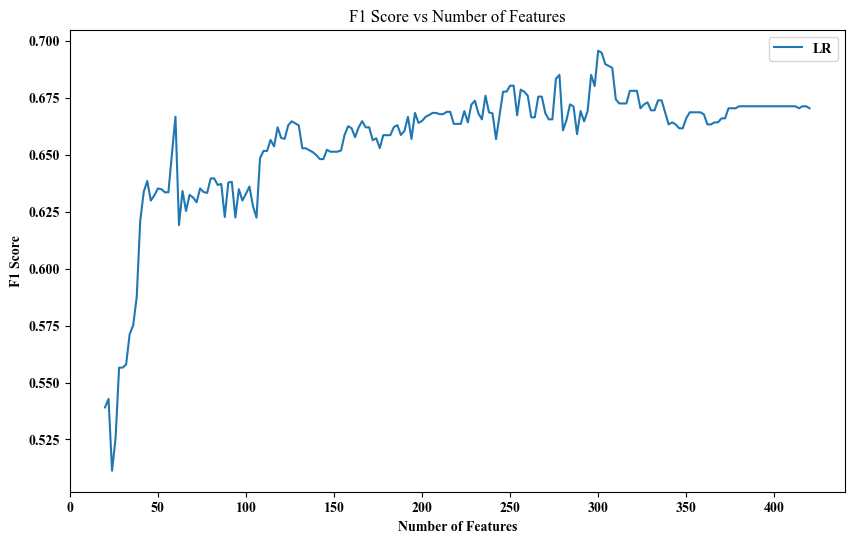

Best Algorithm: LR
Best F1 Score: 0.6956202077234587
Index(['Fp1_Mean', 'Fpz_Mean', 'Fp2_Mean', 'F7_Mean', 'F3_Mean', 'Fz_Mean',
       'F4_Mean', 'F8_Mean', 'FC5_Mean', 'FC1_Mean',
       ...
       'CP6_PSD_Beta', 'P7_PSD_Beta', 'P3_PSD_Beta', 'Pz_PSD_Beta',
       'P4_PSD_Beta', 'P8_PSD_Beta', 'POz_PSD_Beta', 'O1_PSD_Beta',
       'Oz_PSD_Beta', 'O2_PSD_Beta'],
      dtype='object', length=300)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.7848689714427838
The performance of Algorithm DT in the training set is as follows: Accuracy: 0.860 macro-Precision: 0.874 macro-Recall: 0.860 macro-F1: 0.860
The performance of Algorithm DT in the test set is as follows: Accuracy: 0.626 macro-Precision: 0.483 macro-Recall: 0.585 macro-F1: 0.501
The accuracy of the model is： 0.6257449344457687
Evaluation report of the model：
               precision    recall  f1-score   support

        

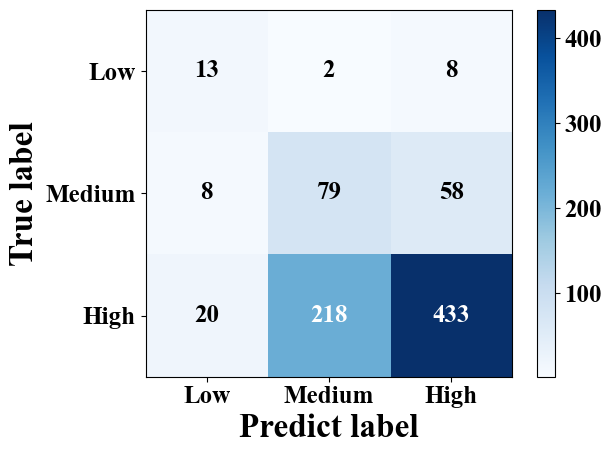

-----------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.9251710493589889
The performance of Algorithm KNN in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm KNN in the test set is as follows: Accuracy: 0.809 macro-Precision: 0.634 macro-Recall: 0.861 macro-F1: 0.699
The accuracy of the model is： 0.8092967818831943
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.43      1.00      0.61        23
           1       0.50      0.77      0.61       145
           2       0.96      0.81      0.88       671

    accuracy                           0.81       839
   macro avg       0.63      0.86      0.70       839
weighted avg       0.87      0.81      0.83       839



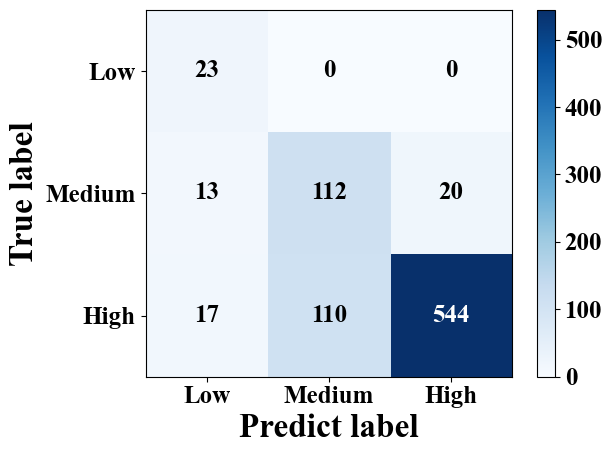

-----------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9632254052954078
The performance of Algorithm SVM in the training set is as follows: Accuracy: 0.991 macro-Precision: 0.991 macro-Recall: 0.991 macro-F1: 0.991
The performance of Algorithm SVM in the test set is as follows: Accuracy: 0.858 macro-Precision: 0.784 macro-Recall: 0.766 macro-F1: 0.774
The accuracy of the model is： 0.8581644815256257
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.62      0.54      0.58       145
           2       0.90      0.93      0.91       671

    accuracy                           0.86       839
   macro avg       0.78      0.77      0.77       839
weighted avg       0.85      0.86      0.85       839



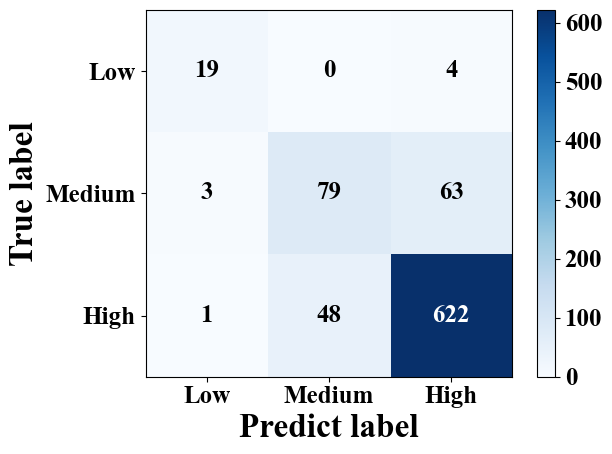

-----------------------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 0.9759809618558799
The performance of Algorithm RF in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm RF in the test set is as follows: Accuracy: 0.871 macro-Precision: 0.801 macro-Recall: 0.758 macro-F1: 0.765
The accuracy of the model is： 0.8712753277711561
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.77      0.87      0.82        23
           1       0.74      0.44      0.55       145
           2       0.89      0.96      0.93       671

    accuracy                           0.87       839
   macro avg       0.80      0.76      0.77       839
weighted avg       0.8

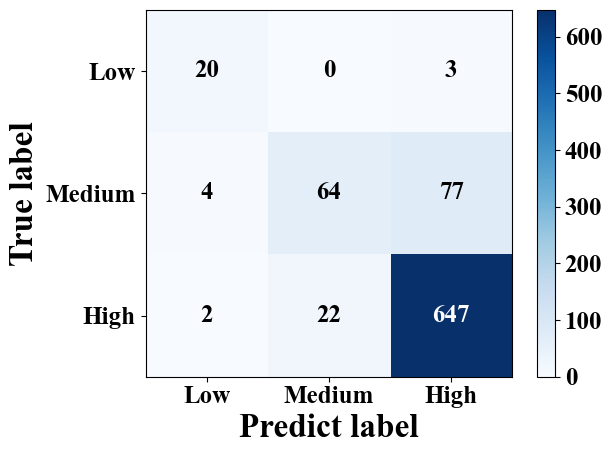

-----------------------------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best score: 0.8762830397720849
The performance of Algorithm AdaBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm AdaBoost in the test set is as follows: Accuracy: 0.735 macro-Precision: 0.520 macro-Recall: 0.616 macro-F1: 0.553
The accuracy of the model is： 0.735399284862932
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.33      0.61      0.43        23
           1       0.36      0.43      0.39       145
           2       0.87      0.80      0.84       671

    accuracy                           0.74       839
   macro avg       0.52      0.62      0.55       839
weighted avg       0.77      0.74      0.75       839



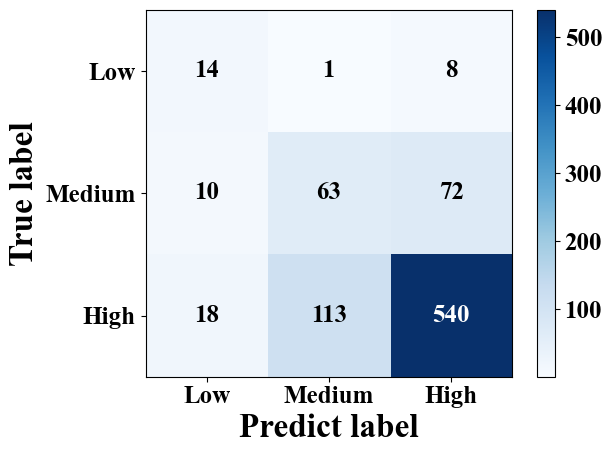

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 200}
Best score: 0.9721529834716349
The performance of Algorithm GBDT in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm GBDT in the test set is as follows: Accuracy: 0.877 macro-Precision: 0.776 macro-Recall: 0.797 macro-F1: 0.782
The accuracy of the model is： 0.8772348033373063
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.70      0.58      0.63       145
           2       0.91      0.94      0.93       671

    accuracy                           0.88       839
   macro avg       0.78      0.80      0.78       839
weighted avg       0.87      0.88      0.87     

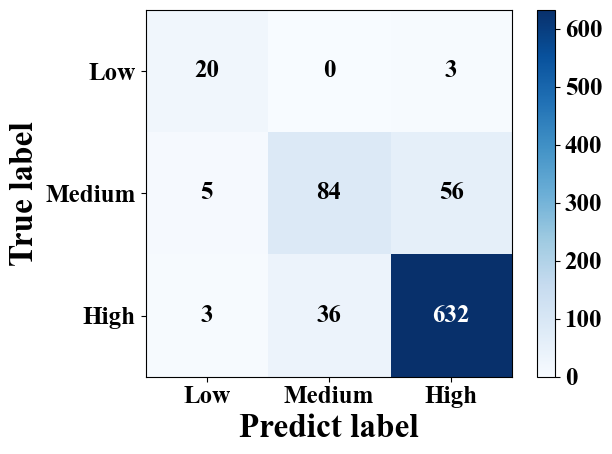

-----------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best score: 0.9757679697922084
The performance of Algorithm XGBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm XGBoost in the test set is as follows: Accuracy: 0.869 macro-Precision: 0.758 macro-Recall: 0.765 macro-F1: 0.755
The accuracy of the model is： 0.8688915375446961
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.68      0.83      0.75        23
           1       0.69      0.52      0.60       145
           2       0.90      0.94      0.92       671

    accuracy                           0.87       839
   macro avg       0.76      0.77      0.76       839
weighted avg       0.86      0.87      0.86       839



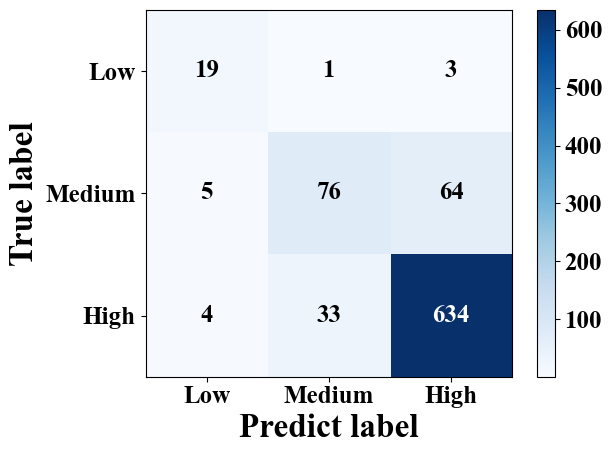

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'boosting_type': 'goss', 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.980019897347774
The performance of Algorithm LightGBM in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm LightGBM in the test set is as follows: Accuracy: 0.884 macro-Precision: 0.812 macro-Recall: 0.780 macro-F1: 0.783
The accuracy of the model is： 0.8843861740166865
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.74      0.87      0.80        23
           1       0.79      0.50      0.62       145
           2       0.90      0.97      0.93       671

    accuracy                           0.88       839
   macro avg       0.81      0.78      0.78       839
weighted avg       0.88      0.88    

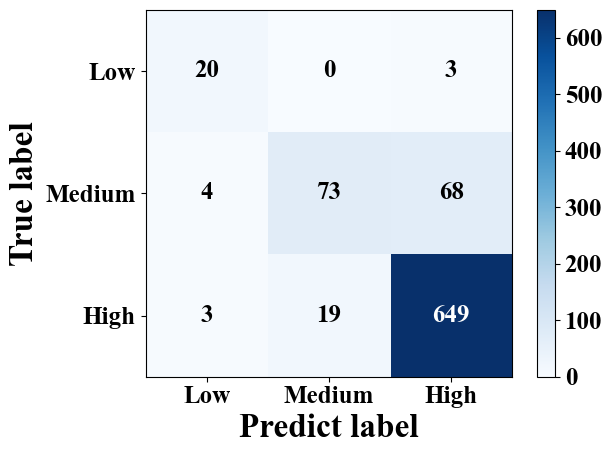

-----------------------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9698139145770682
The performance of Algorithm MLP in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm MLP in the test set is as follows: Accuracy: 0.853 macro-Precision: 0.731 macro-Recall: 0.792 macro-F1: 0.755
The accuracy of the model is： 0.8533969010727056
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.68      0.91      0.78        23
           1       0.61      0.54      0.57       145
           2       0.91      0.92      0.91       671

    accuracy                           0.85       839
   macro avg       0.73      0.79      0.76       839
weighted avg       0.85      0.85 

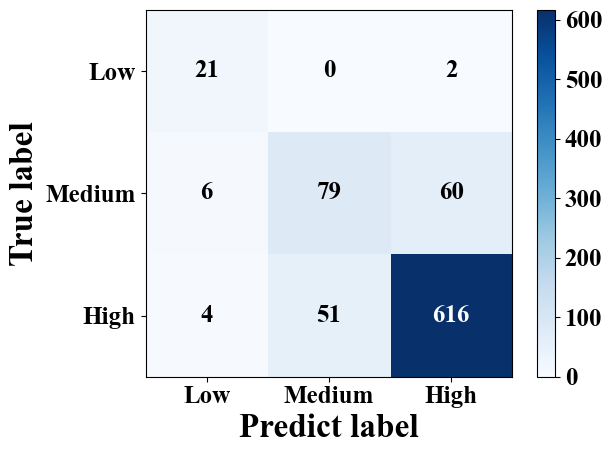

-----------------------------------------------------------------


In [34]:
# Whole brain
chEEGResultInfo = stepIntegration(chEEGFeatures, TrustLabel, 'EEG')

In [35]:
chEEGResultInfo

Algorithm     Value  ValueType  \
0         DT  0.625745        ACC   
1        KNN  0.809297        ACC   
2        SVM  0.858164        ACC   
3         RF  0.871275        ACC   
4   AdaBoost  0.735399        ACC   
5       GBDT  0.877235        ACC   
6    XGBoost  0.868892        ACC   
7   LightGBM  0.884386        ACC   
8        MLP  0.853397        ACC   
9         DT  0.483008  Precision   
10       KNN  0.634335  Precision   
11       SVM  0.783631  Precision   
12        RF  0.801125  Precision   
13  AdaBoost  0.520078  Precision   
14      GBDT  0.776301  Precision   
15   XGBoost  0.757968  Precision   
16  LightGBM  0.811869  Precision   
17       MLP  0.731222  Precision   
18        DT  0.585117     Recall   
19       KNN  0.861048     Recall   
20       SVM  0.765963     Recall   
21        RF  0.758392     Recall   
22  AdaBoost  0.615982     Recall   
23      GBDT  0.796918     Recall   
24   XGBoost  0.765028     Recall   
25  LightGBM  0.780076     Recall   
26       MLP  0.791968     Recall   
27        DT  0.500759   F1-score   
28       KNN  0.698863   F1-score   
29       SVM  0.773892   F1-score   
30        RF  0.765349   F1-score   
31  AdaBoost  0.552878   F1-score   
32      GBDT  0.782108   F1-score   
33   XGBoost  0.755125   F1-score   
34  LightGBM  0.783058   F1-score   
35       MLP  0.755197   F1-score   

                                           BestParams DataType  Seed  
0   {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...      EEG    42  
1   {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}      EEG    42  
2        {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}      EEG    42  
3   {'max_depth': None, 'max_features': 'auto', 'm...      EEG    42  
4   {'algorithm': 'SAMME', 'learning_rate': 0.1, '...      EEG    42  
5   {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...      EEG    42  
6   {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...      EEG    42  
7   {'boosting_type': 'goss', 'learning_rate': 0.1...      EEG    42  
8   {'activation': 'relu', 'hidden_layer_sizes': (...      EEG    42  
9   {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...      EEG    42  
10  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}      EEG    42  
11       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}      EEG    42  
12  {'max_depth': None, 'max_features': 'auto', 'm...      EEG    42  
13  {'algorithm': 'SAMME', 'learning_rate': 0.1, '...      EEG    42  
14  {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...      EEG    42  
15  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...      EEG    42  
16  {'boosting_type': 'goss', 'learning_rate': 0.1...      EEG    42  
17  {'activation': 'relu', 'hidden_layer_sizes': (...      EEG    42  
18  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...      EEG    42  
19  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}      EEG    42  
20       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}      EEG    42  
21  {'max_depth': None, 'max_features': 'auto', 'm...      EEG    42  
22  {'algorithm': 'SAMME', 'learning_rate': 0.1, '...      EEG    42  
23  {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...      EEG    42  
24  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...      EEG    42  
25  {'boosting_type': 'goss', 'learning_rate': 0.1...      EEG    42  
26  {'activation': 'relu', 'hidden_layer_sizes': (...      EEG    42  
27  {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...      EEG    42  
28  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}      EEG    42  
29       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}      EEG    42  
30  {'max_depth': None, 'max_features': 'auto', 'm...      EEG    42  
31  {'algorithm': 'SAMME', 'learning_rate': 0.1, '...      EEG    42  
32  {'learning_rate': 0.5, 'max_depth': 5, 'min_sa...      EEG    42  
33  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...      EEG    42  
34  {'boosting_type': 'goss', 'learning_rate': 0.1...      EEG    42  
35  {'activation': 'relu', 'hidden_layer_sizes': (...      EEG    42

In [36]:
chEEGResultInfo.to_csv('D:/EEGData/EEG.csv', index=False, mode='w')

### Individual brain regions

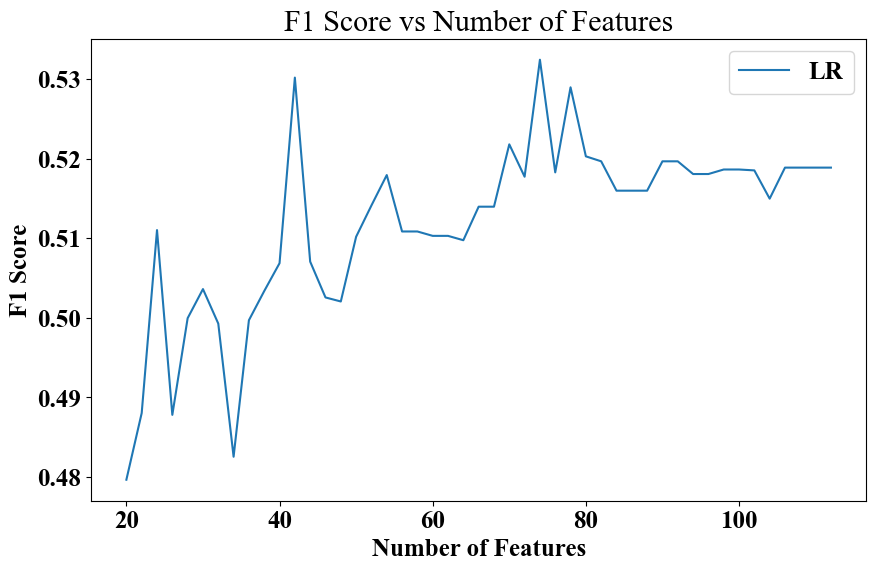

Best Algorithm: LR
Best F1 Score: 0.5324389999799836
Index(['Fp1_Mean', 'Fpz_Mean', 'Fp2_Mean', 'F7_Mean', 'F3_Mean', 'Fz_Mean',
       'F4_Mean', 'F8_Mean', 'FC5_Mean', 'FC1_Mean', 'FC2_Mean', 'FC6_Mean',
       'T7_Mean', 'C3_Mean', 'Cz_Mean', 'C4_Mean', 'T8_Mean', 'CP5_Mean',
       'CP1_Mean', 'CP2_Mean', 'CP6_Mean', 'P7_Mean', 'P3_Mean', 'Pz_Mean',
       'P4_Mean', 'P8_Mean', 'POz_Mean', 'O1_Mean', 'Oz_Mean', 'O2_Mean',
       'Fp1_Std', 'Fpz_Std', 'Fp2_Std', 'F7_Std', 'F3_Std', 'Fz_Std', 'F4_Std',
       'F8_Std', 'FC5_Std', 'FC1_Std', 'FC2_Std', 'FC6_Std', 'T7_Std',
       'C3_Std', 'Cz_Std', 'C4_Std', 'T8_Std', 'CP5_Std', 'CP1_Std', 'CP2_Std',
       'CP6_Std', 'P7_Std', 'P3_Std', 'Pz_Std', 'P4_Std', 'P8_Std', 'POz_Std',
       'O1_Std', 'Oz_Std', 'O2_Std', 'Fp1_Min', 'Fpz_Min', 'Fp2_Min', 'F7_Min',
       'F3_Min', 'Fz_Min', 'F4_Min', 'F8_Min', 'FC5_Min', 'FC1_Min', 'FC2_Min',
       'FC6_Min', 'T7_Min', 'C3_Min'],
      dtype='object')
Fitting 5 folds for each of 27 candidat

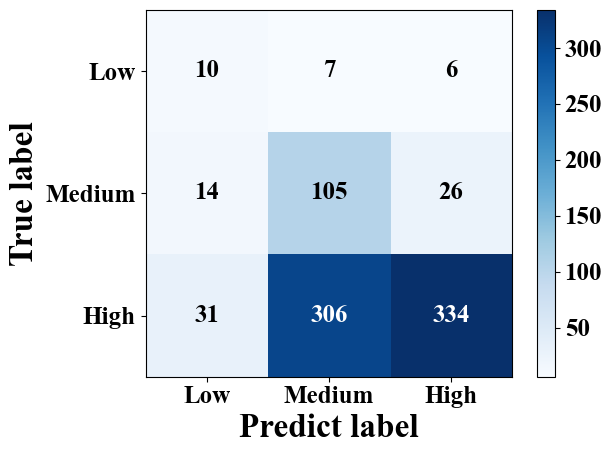

-----------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.928572139190992
The performance of Algorithm KNN in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm KNN in the test set is as follows: Accuracy: 0.795 macro-Precision: 0.606 macro-Recall: 0.823 macro-F1: 0.665
The accuracy of the model is： 0.7949940405244339
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.38      0.96      0.54        23
           1       0.49      0.70      0.58       145
           2       0.95      0.81      0.87       671

    accuracy                           0.79       839
   macro avg       0.61      0.82      0.67       839
weighted avg       0.85      0.79      0.81       839



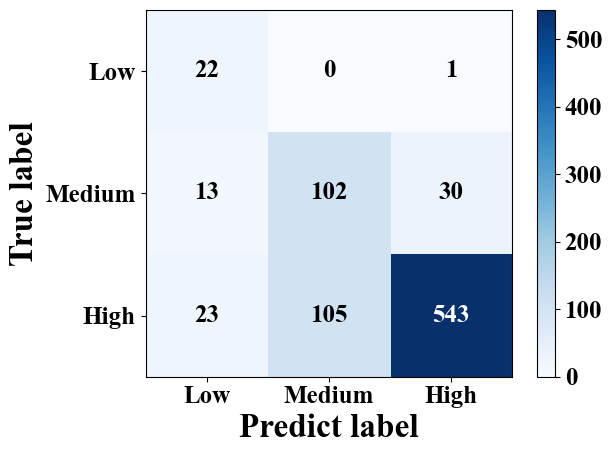

-----------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9358021118321387
The performance of Algorithm SVM in the training set is as follows: Accuracy: 0.966 macro-Precision: 0.966 macro-Recall: 0.966 macro-F1: 0.966
The performance of Algorithm SVM in the test set is as follows: Accuracy: 0.833 macro-Precision: 0.651 macro-Recall: 0.707 macro-F1: 0.675
The accuracy of the model is： 0.833134684147795
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.48      0.65      0.56        23
           1       0.56      0.57      0.56       145
           2       0.91      0.90      0.90       671

    accuracy                           0.83       839
   macro avg       0.65      0.71      0.67       839
weighted avg       0.84      0.83      0.84       839



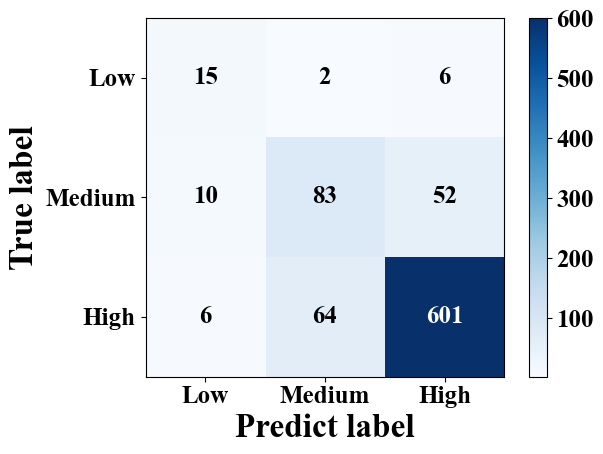

-----------------------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9655644741899744
The performance of Algorithm RF in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm RF in the test set is as follows: Accuracy: 0.859 macro-Precision: 0.723 macro-Recall: 0.743 macro-F1: 0.719
The accuracy of the model is： 0.8593563766388558
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.59      0.83      0.69        23
           1       0.68      0.46      0.55       145
           2       0.90      0.95      0.92       671

    accuracy                           0.86       839
   macro avg       0.72      0.74      0.72       839
weighted avg       0.8

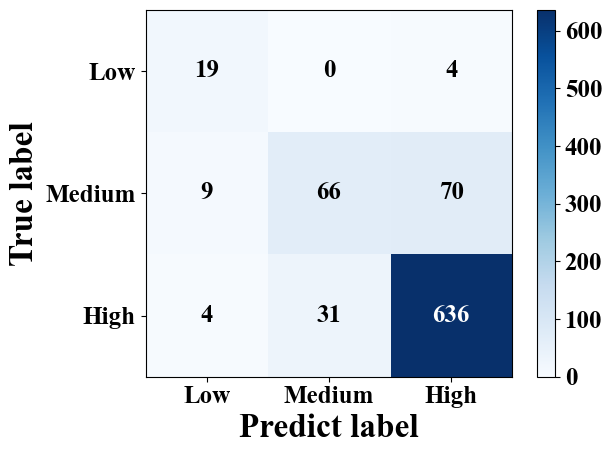

-----------------------------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best score: 0.8645840775996565
The performance of Algorithm AdaBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm AdaBoost in the test set is as follows: Accuracy: 0.749 macro-Precision: 0.520 macro-Recall: 0.629 macro-F1: 0.552
The accuracy of the model is： 0.7485101311084624
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.25      0.57      0.35        23
           1       0.41      0.52      0.46       145
           2       0.89      0.80      0.85       671

    accuracy                           0.75       839
   macro avg       0.52      0.63      0.55       839
weighted avg       0.79      0.75      0.77       839



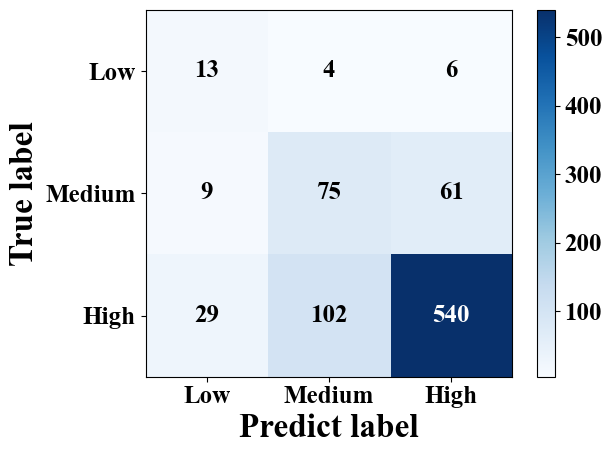

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9659884233612951
The performance of Algorithm GBDT in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm GBDT in the test set is as follows: Accuracy: 0.858 macro-Precision: 0.734 macro-Recall: 0.731 macro-F1: 0.729
The accuracy of the model is： 0.8581644815256257
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.65      0.74      0.69        23
           1       0.65      0.52      0.57       145
           2       0.90      0.94      0.92       671

    accuracy                           0.86       839
   macro avg       0.73      0.73      0.73       839
weighted avg       0.85      0.86      0.85     

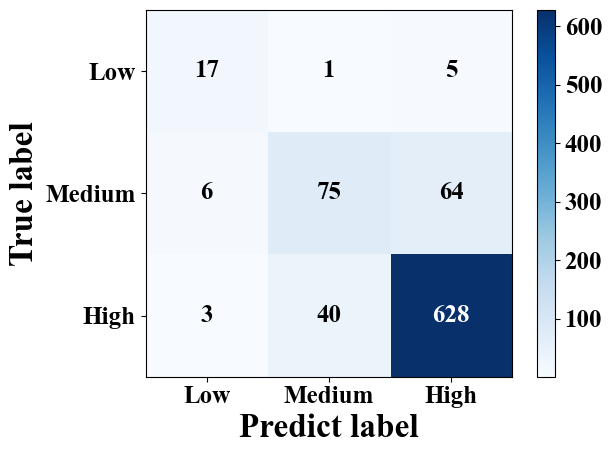

-----------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best score: 0.9649257241051845
The performance of Algorithm XGBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm XGBoost in the test set is as follows: Accuracy: 0.869 macro-Precision: 0.752 macro-Recall: 0.763 macro-F1: 0.752
The accuracy of the model is： 0.8688915375446961
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.68      0.83      0.75        23
           1       0.67      0.52      0.58       145
           2       0.91      0.95      0.93       671

    accuracy                           0.87       839
   macro avg       0.75      0.76      0.75       839
weighted avg       0.86      0.87      0.86       839



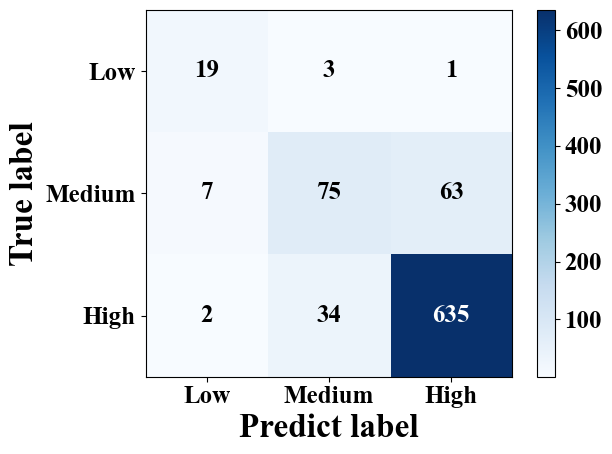

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'boosting_type': 'goss', 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.9715155900241934
The performance of Algorithm LightGBM in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm LightGBM in the test set is as follows: Accuracy: 0.877 macro-Precision: 0.762 macro-Recall: 0.763 macro-F1: 0.753
The accuracy of the model is： 0.8772348033373063
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.66      0.83      0.73        23
           1       0.72      0.50      0.59       145
           2       0.91      0.96      0.93       671

    accuracy                           0.88       839
   macro avg       0.76      0.76      0.75       839
weighted avg       0.87      0.88   

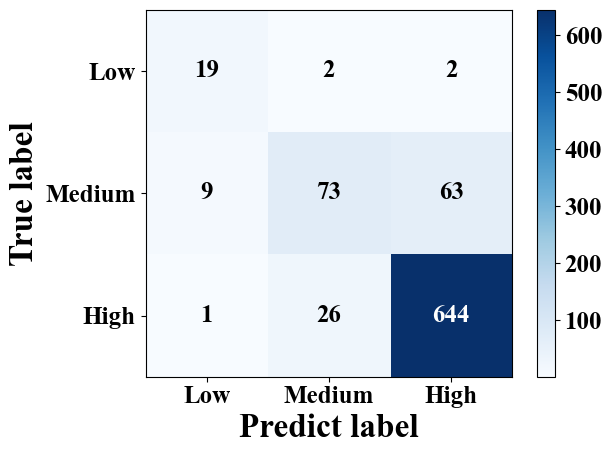

-----------------------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9630117349130621
The performance of Algorithm MLP in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm MLP in the test set is as follows: Accuracy: 0.853 macro-Precision: 0.674 macro-Recall: 0.731 macro-F1: 0.692
The accuracy of the model is： 0.8533969010727056
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.49      0.74      0.59        23
           1       0.62      0.52      0.57       145
           2       0.91      0.93      0.92       671

    accuracy                           0.85       839
   macro avg       0.67      0.73      0.69       839
weighted avg       0.85      0.85 

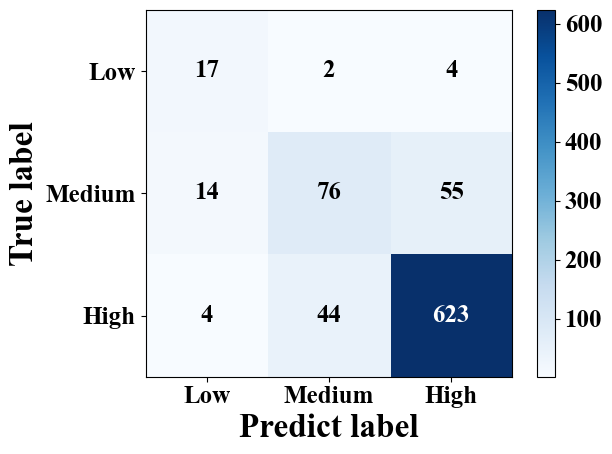

-----------------------------------------------------------------


In [37]:
# Frontal region
EEGEQuResultInfo = stepIntegration(EEGEQuFeatures, TrustLabel, 'EEG_EQu')

In [38]:
EEGEQuResultInfo.to_csv('D:/EEGData/EEG_EQu.csv', index=False, mode='w')

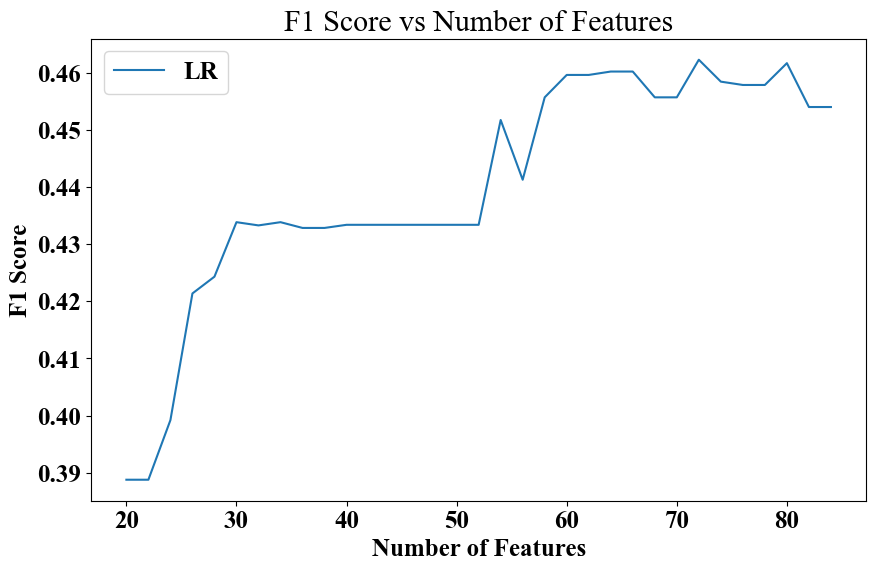

Best Algorithm: LR
Best F1 Score: 0.462292190218442
Index(['Fp1_Mean', 'Fpz_Mean', 'Fp2_Mean', 'F7_Mean', 'F3_Mean', 'Fz_Mean',
       'F4_Mean', 'F8_Mean', 'FC5_Mean', 'FC1_Mean', 'FC2_Mean', 'FC6_Mean',
       'T7_Mean', 'C3_Mean', 'Cz_Mean', 'C4_Mean', 'T8_Mean', 'CP5_Mean',
       'CP1_Mean', 'CP2_Mean', 'CP6_Mean', 'P7_Mean', 'P3_Mean', 'Pz_Mean',
       'P4_Mean', 'P8_Mean', 'POz_Mean', 'O1_Mean', 'Oz_Mean', 'O2_Mean',
       'Fp1_Std', 'Fpz_Std', 'Fp2_Std', 'F7_Std', 'F3_Std', 'Fz_Std', 'F4_Std',
       'F8_Std', 'FC5_Std', 'FC1_Std', 'FC2_Std', 'FC6_Std', 'T7_Std',
       'C3_Std', 'Cz_Std', 'C4_Std', 'T8_Std', 'CP5_Std', 'CP1_Std', 'CP2_Std',
       'CP6_Std', 'P7_Std', 'P3_Std', 'Pz_Std', 'P4_Std', 'P8_Std', 'POz_Std',
       'O1_Std', 'Oz_Std', 'O2_Std', 'Fp1_Min', 'Fpz_Min', 'Fp2_Min', 'F7_Min',
       'F3_Min', 'Fz_Min', 'F4_Min', 'F8_Min', 'FC5_Min', 'FC1_Min', 'FC2_Min',
       'FC6_Min'],
      dtype='object')
Fitting 5 folds for each of 27 candidates, totalling 135 fit

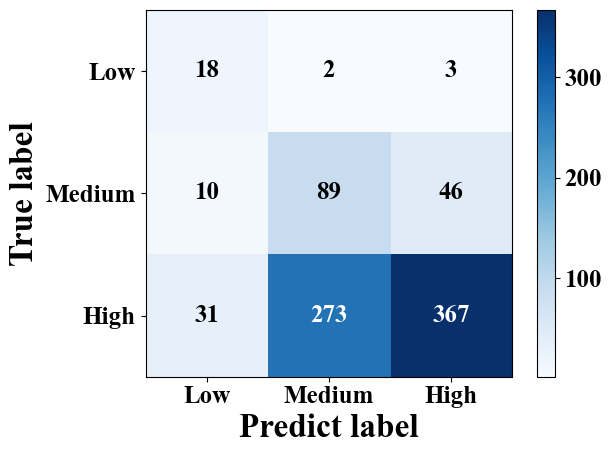

-----------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.9124170755420897
The performance of Algorithm KNN in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm KNN in the test set is as follows: Accuracy: 0.770 macro-Precision: 0.588 macro-Recall: 0.818 macro-F1: 0.645
The accuracy of the model is： 0.7699642431466031
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.36      0.96      0.52        23
           1       0.45      0.72      0.56       145
           2       0.95      0.77      0.85       671

    accuracy                           0.77       839
   macro avg       0.59      0.82      0.64       839
weighted avg       0.85      0.77      0.79       839



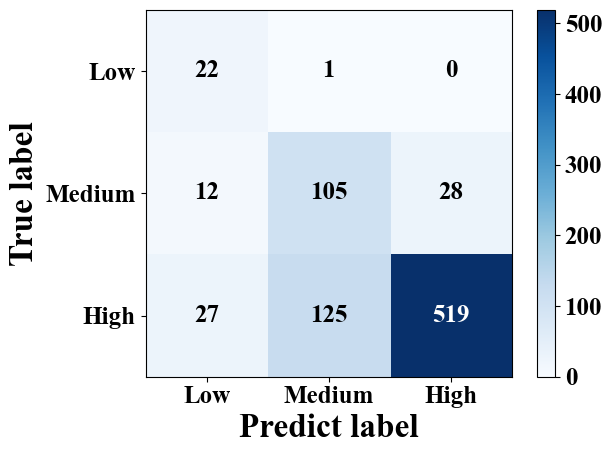

-----------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9351624573224502
The performance of Algorithm SVM in the training set is as follows: Accuracy: 0.970 macro-Precision: 0.970 macro-Recall: 0.970 macro-F1: 0.970
The performance of Algorithm SVM in the test set is as follows: Accuracy: 0.805 macro-Precision: 0.604 macro-Recall: 0.705 macro-F1: 0.640
The accuracy of the model is： 0.8045292014302742
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.42      0.74      0.54        23
           1       0.49      0.50      0.49       145
           2       0.90      0.87      0.89       671

    accuracy                           0.80       839
   macro avg       0.60      0.70      0.64       839
weighted avg       0.82      0.80      0.81       839



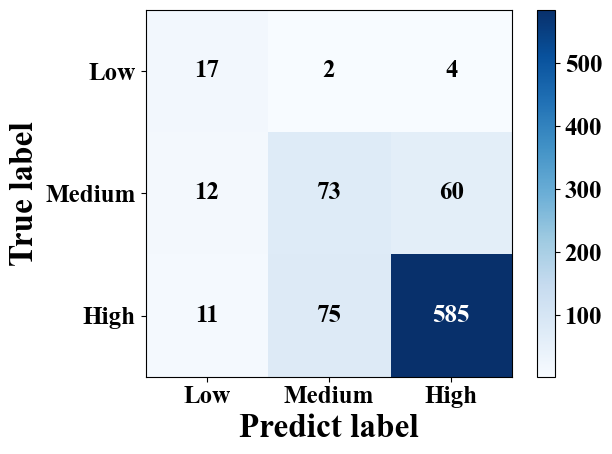

-----------------------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 0.9713028240667466
The performance of Algorithm RF in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm RF in the test set is as follows: Accuracy: 0.851 macro-Precision: 0.742 macro-Recall: 0.731 macro-F1: 0.727
The accuracy of the model is： 0.8510131108462455
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.64      0.42      0.51       145
           2       0.89      0.94      0.91       671

    accuracy                           0.85       839
   macro avg       0.74      0.73      0.73       839
weighted avg       0.8

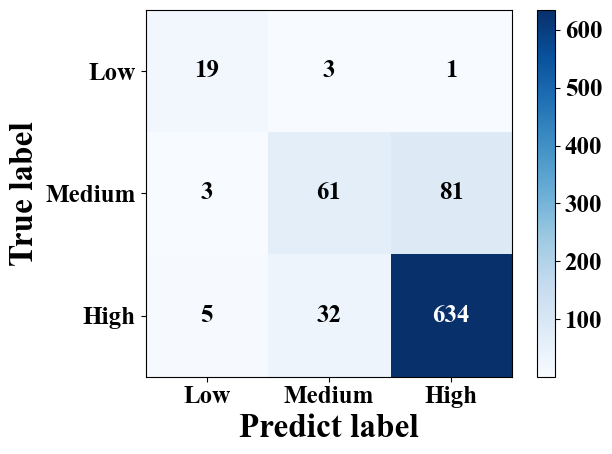

-----------------------------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best score: 0.8624525742193683
The performance of Algorithm AdaBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm AdaBoost in the test set is as follows: Accuracy: 0.733 macro-Precision: 0.520 macro-Recall: 0.643 macro-F1: 0.558
The accuracy of the model is： 0.733015494636472
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.33      0.70      0.45        23
           1       0.35      0.43      0.39       145
           2       0.88      0.80      0.84       671

    accuracy                           0.73       839
   macro avg       0.52      0.64      0.56       839
weighted avg       0.77      0.73      0.75       839



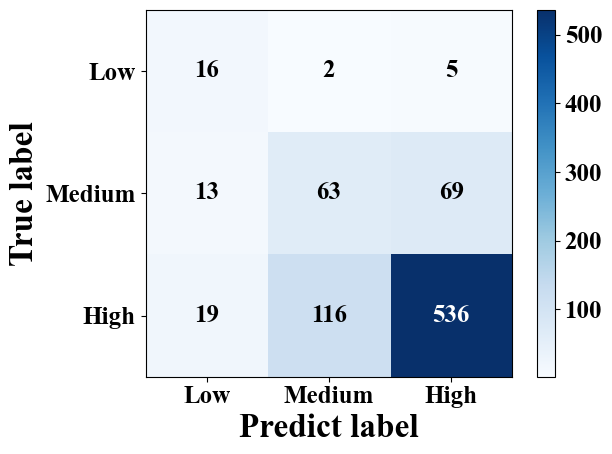

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9608863364008412
The performance of Algorithm GBDT in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm GBDT in the test set is as follows: Accuracy: 0.845 macro-Precision: 0.725 macro-Recall: 0.719 macro-F1: 0.717
The accuracy of the model is： 0.8450536352800954
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.69      0.78      0.73        23
           1       0.59      0.44      0.51       145
           2       0.89      0.93      0.91       671

    accuracy                           0.85       839
   macro avg       0.72      0.72      0.72       839
weighted avg       0.83      0.85      0.84     

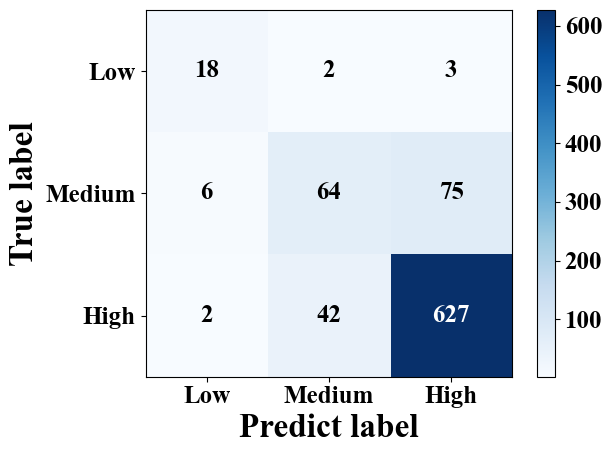

-----------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best score: 0.9627994211680647
The performance of Algorithm XGBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm XGBoost in the test set is as follows: Accuracy: 0.861 macro-Precision: 0.727 macro-Recall: 0.718 macro-F1: 0.718
The accuracy of the model is： 0.8605482717520858
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.62      0.70      0.65        23
           1       0.66      0.52      0.58       145
           2       0.90      0.94      0.92       671

    accuracy                           0.86       839
   macro avg       0.73      0.72      0.72       839
weighted avg       0.85      0.86      0.85       839



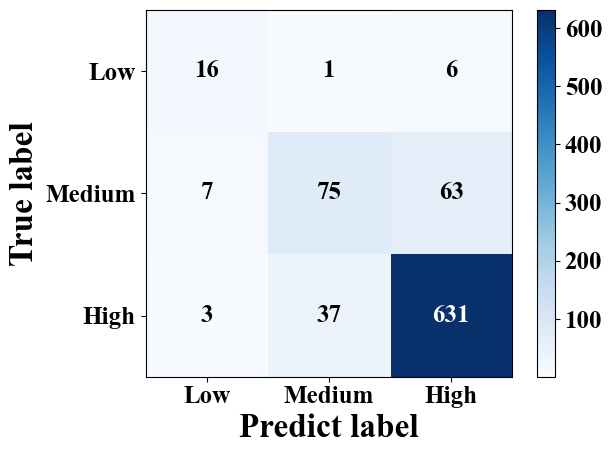

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.9727910552377507
The performance of Algorithm LightGBM in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm LightGBM in the test set is as follows: Accuracy: 0.859 macro-Precision: 0.789 macro-Recall: 0.708 macro-F1: 0.738
The accuracy of the model is： 0.8593563766388558
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.67      0.43      0.52       145
           2       0.88      0.96      0.92       671

    accuracy                           0.86       839
   macro avg       0.79      0.71      0.74       839
weighted avg       0.85      0.86   

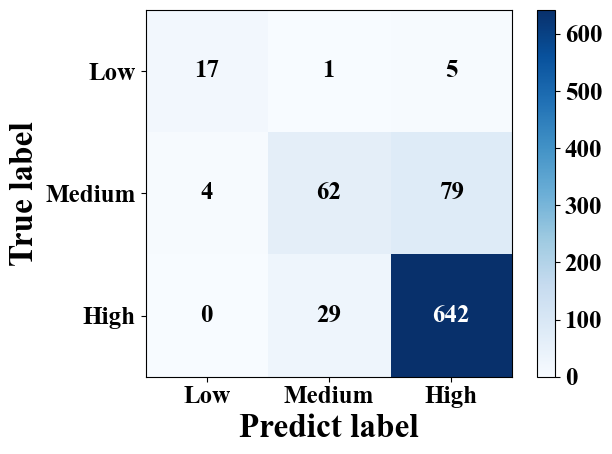

-----------------------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9583360842924005
The performance of Algorithm MLP in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm MLP in the test set is as follows: Accuracy: 0.820 macro-Precision: 0.633 macro-Recall: 0.718 macro-F1: 0.663
The accuracy of the model is： 0.8200238379022646
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.47      0.78      0.59        23
           1       0.53      0.48      0.50       145
           2       0.90      0.90      0.90       671

    accuracy                           0.82       839
   macro avg       0.63      0.72      0.66       839
weighted avg       0.82      0.82 

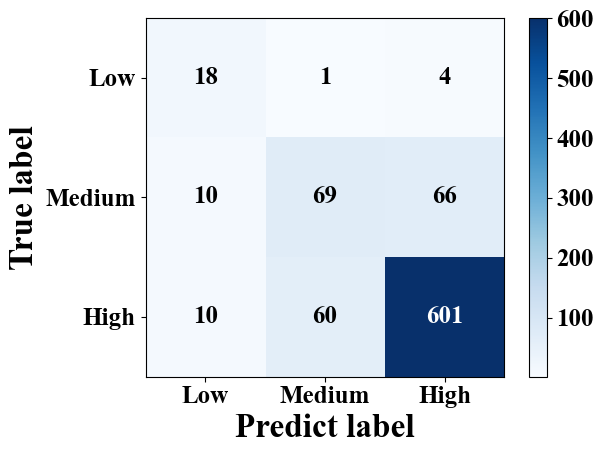

-----------------------------------------------------------------


In [39]:
# Temporal region
EEGNieQuResultInfo = stepIntegration(EEGNieQuFeatures, TrustLabel, 'EEG_NieQu')

In [40]:
EEGNieQuResultInfo.to_csv('D:/EEGData/EEG_NieQu.csv', index=False, mode='w')

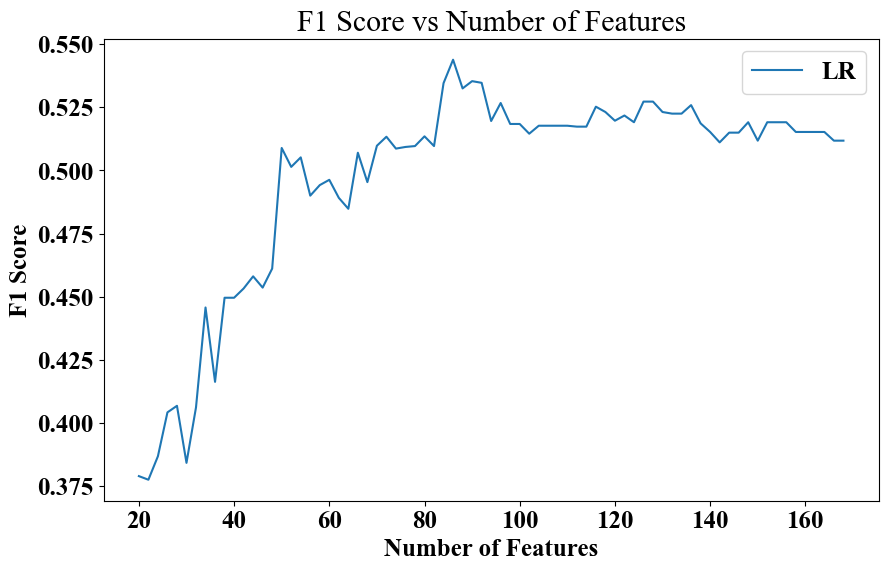

Best Algorithm: LR
Best F1 Score: 0.5438080982038641
Index(['Fp1_Mean', 'Fpz_Mean', 'Fp2_Mean', 'F7_Mean', 'F3_Mean', 'Fz_Mean',
       'F4_Mean', 'F8_Mean', 'FC5_Mean', 'FC1_Mean', 'FC2_Mean', 'FC6_Mean',
       'T7_Mean', 'C3_Mean', 'Cz_Mean', 'C4_Mean', 'T8_Mean', 'CP5_Mean',
       'CP1_Mean', 'CP2_Mean', 'CP6_Mean', 'P7_Mean', 'P3_Mean', 'Pz_Mean',
       'P4_Mean', 'P8_Mean', 'POz_Mean', 'O1_Mean', 'Oz_Mean', 'O2_Mean',
       'Fp1_Std', 'Fpz_Std', 'Fp2_Std', 'F7_Std', 'F3_Std', 'Fz_Std', 'F4_Std',
       'F8_Std', 'FC5_Std', 'FC1_Std', 'FC2_Std', 'FC6_Std', 'T7_Std',
       'C3_Std', 'Cz_Std', 'C4_Std', 'T8_Std', 'CP5_Std', 'CP1_Std', 'CP2_Std',
       'CP6_Std', 'P7_Std', 'P3_Std', 'Pz_Std', 'P4_Std', 'P8_Std', 'POz_Std',
       'O1_Std', 'Oz_Std', 'O2_Std', 'Fp1_Min', 'Fpz_Min', 'Fp2_Min', 'F7_Min',
       'F3_Min', 'Fz_Min', 'F4_Min', 'F8_Min', 'FC5_Min', 'FC1_Min', 'FC2_Min',
       'FC6_Min', 'T7_Min', 'C3_Min', 'Cz_Min', 'C4_Min', 'T8_Min', 'CP5_Min',
       'CP1_Min', 'CP

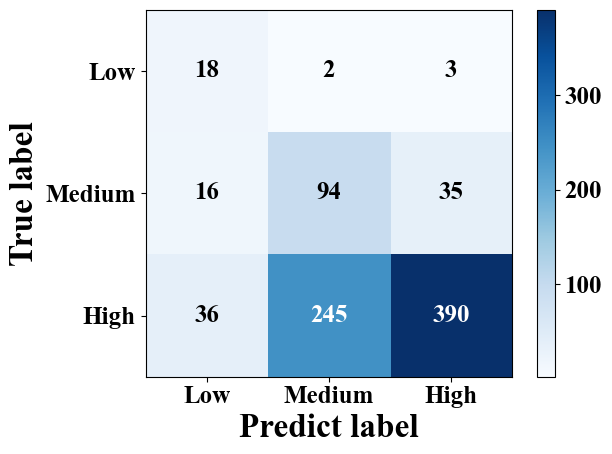

-----------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.9209191218034233
The performance of Algorithm KNN in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm KNN in the test set is as follows: Accuracy: 0.781 macro-Precision: 0.605 macro-Recall: 0.823 macro-F1: 0.664
The accuracy of the model is： 0.7806912991656734
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.41      0.96      0.57        23
           1       0.45      0.72      0.56       145
           2       0.95      0.79      0.86       671

    accuracy                           0.78       839
   macro avg       0.60      0.82      0.66       839
weighted avg       0.85      0.78      0.80       839



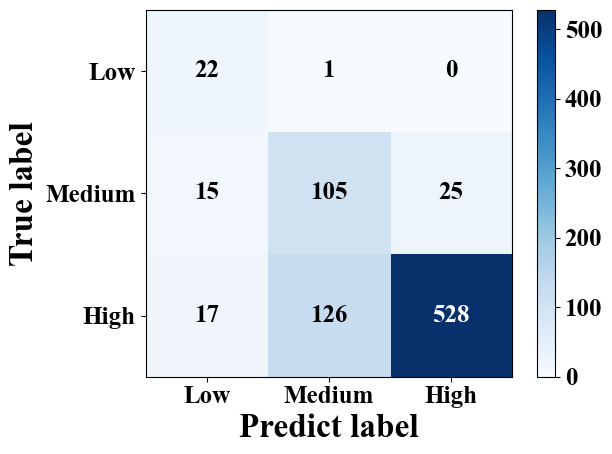

-----------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.9324017003188099
The performance of Algorithm SVM in the training set is as follows: Accuracy: 0.963 macro-Precision: 0.964 macro-Recall: 0.963 macro-F1: 0.963
The performance of Algorithm SVM in the test set is as follows: Accuracy: 0.799 macro-Precision: 0.649 macro-Recall: 0.779 macro-F1: 0.698
The accuracy of the model is： 0.798569725864124
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.56      0.87      0.68        23
           1       0.48      0.63      0.55       145
           2       0.91      0.83      0.87       671

    accuracy                           0.80       839
   macro avg       0.65      0.78      0.70       839
weighted avg       0.83      0.80      0.81       839



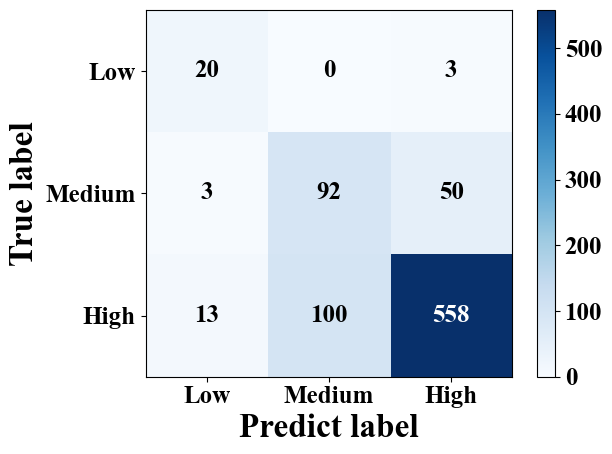

-----------------------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9725791937052026
The performance of Algorithm RF in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm RF in the test set is as follows: Accuracy: 0.867 macro-Precision: 0.768 macro-Recall: 0.755 macro-F1: 0.745
The accuracy of the model is： 0.866507747318236
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.69      0.87      0.77        23
           1       0.72      0.43      0.54       145
           2       0.89      0.96      0.92       671

    accuracy                           0.87       839
   macro avg       0.77      0.75      0.75       839
weighted avg       0.86

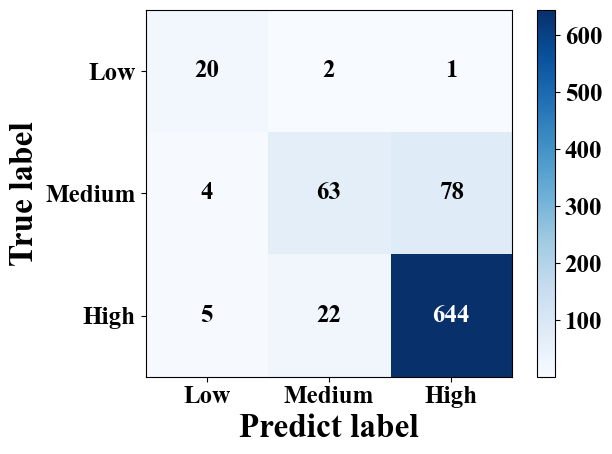

-----------------------------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best score: 0.8633088384923238
The performance of Algorithm AdaBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm AdaBoost in the test set is as follows: Accuracy: 0.732 macro-Precision: 0.504 macro-Recall: 0.624 macro-F1: 0.537
The accuracy of the model is： 0.7318235995232419
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.25      0.61      0.36        23
           1       0.38      0.47      0.42       145
           2       0.88      0.79      0.83       671

    accuracy                           0.73       839
   macro avg       0.50      0.62      0.54       839
weighted avg       0.78      0.73      0.75       839



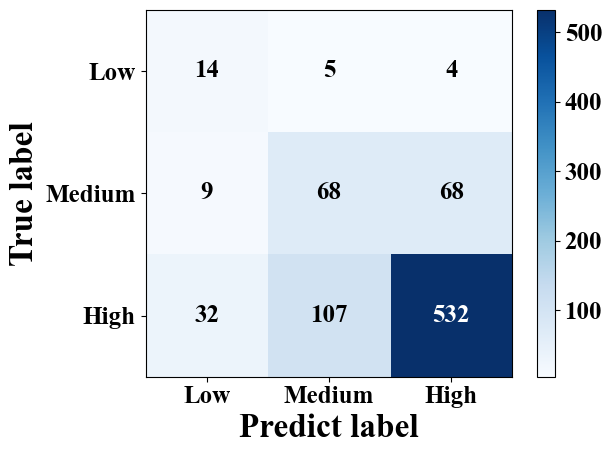

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200}
Best score: 0.9676894204897462
The performance of Algorithm GBDT in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm GBDT in the test set is as follows: Accuracy: 0.855 macro-Precision: 0.713 macro-Recall: 0.774 macro-F1: 0.729
The accuracy of the model is： 0.8545887961859356
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.60      0.91      0.72        23
           1       0.64      0.48      0.55       145
           2       0.90      0.93      0.92       671

    accuracy                           0.85       839
   macro avg       0.71      0.77      0.73       839
weighted avg       0.85      0.85      0.85     

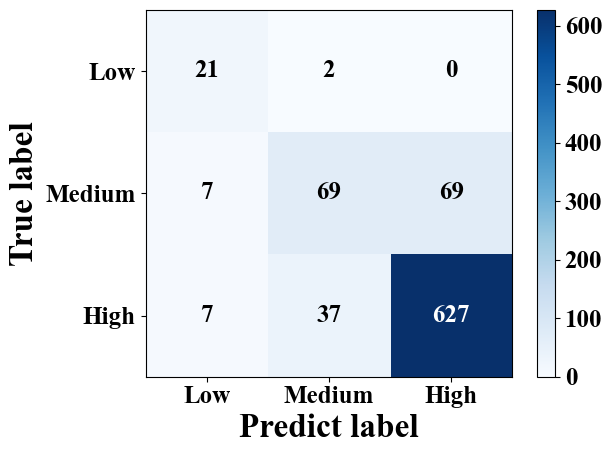

-----------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best score: 0.9700280371718634
The performance of Algorithm XGBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm XGBoost in the test set is as follows: Accuracy: 0.861 macro-Precision: 0.726 macro-Recall: 0.762 macro-F1: 0.736
The accuracy of the model is： 0.8605482717520858
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.61      0.83      0.70        23
           1       0.66      0.52      0.58       145
           2       0.90      0.93      0.92       671

    accuracy                           0.86       839
   macro avg       0.73      0.76      0.74       839
weighted avg       0.85      0.86      0.86       839



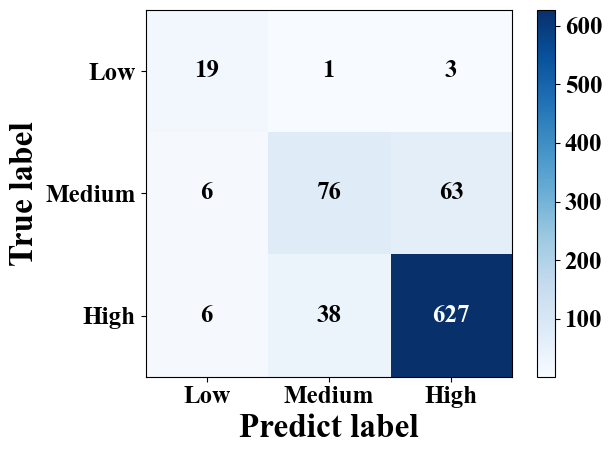

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.9768299907296448
The performance of Algorithm LightGBM in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm LightGBM in the test set is as follows: Accuracy: 0.869 macro-Precision: 0.747 macro-Recall: 0.735 macro-F1: 0.725
The accuracy of the model is： 0.8688915375446961
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.60      0.78      0.68        23
           1       0.74      0.46      0.57       145
           2       0.90      0.96      0.93       671

    accuracy                           0.87       839
   macro avg       0.75      0.73      0.73       839
weighted avg       0.86      0.87   

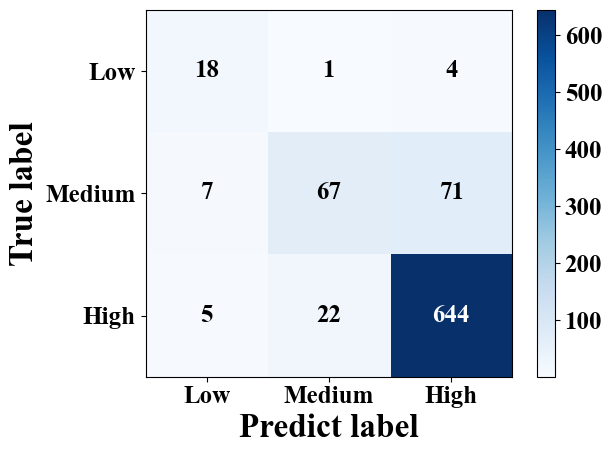

-----------------------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9593983313360617
The performance of Algorithm MLP in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm MLP in the test set is as follows: Accuracy: 0.833 macro-Precision: 0.691 macro-Recall: 0.776 macro-F1: 0.721
The accuracy of the model is： 0.833134684147795
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.63      0.96      0.76        23
           1       0.55      0.46      0.50       145
           2       0.89      0.91      0.90       671

    accuracy                           0.83       839
   macro avg       0.69      0.78      0.72       839
weighted avg       0.83      0.83

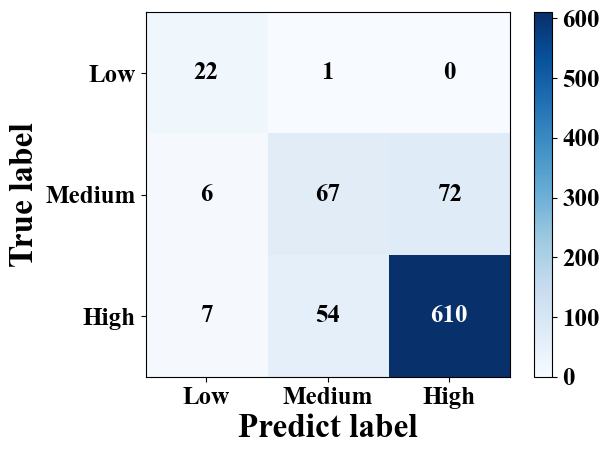

-----------------------------------------------------------------


In [41]:
# Apical region
EEGDingQuResultInfo = stepIntegration(EEGDingQuFeatures, TrustLabel, 'EEG_DingQu')

In [42]:
EEGDingQuResultInfo.to_csv('D:/EEGData/EEG_DingQu.csv', index=False, mode='w')

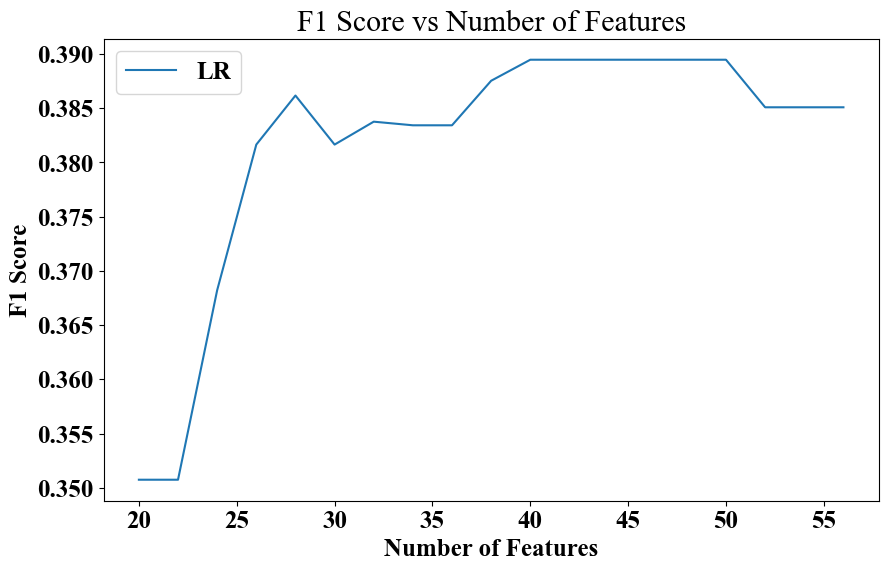

Best Algorithm: LR
Best F1 Score: 0.38947798344712786
Index(['Fp1_Mean', 'Fpz_Mean', 'Fp2_Mean', 'F7_Mean', 'F3_Mean', 'Fz_Mean',
       'F4_Mean', 'F8_Mean', 'FC5_Mean', 'FC1_Mean', 'FC2_Mean', 'FC6_Mean',
       'T7_Mean', 'C3_Mean', 'Cz_Mean', 'C4_Mean', 'T8_Mean', 'CP5_Mean',
       'CP1_Mean', 'CP2_Mean', 'CP6_Mean', 'P7_Mean', 'P3_Mean', 'Pz_Mean',
       'P4_Mean', 'P8_Mean', 'POz_Mean', 'O1_Mean', 'Oz_Mean', 'O2_Mean',
       'Fp1_Std', 'Fpz_Std', 'Fp2_Std', 'F7_Std', 'F3_Std', 'Fz_Std', 'F4_Std',
       'F8_Std', 'FC5_Std', 'FC1_Std'],
      dtype='object')
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.7374551744409523
The performance of Algorithm DT in the training set is as follows: Accuracy: 0.769 macro-Precision: 0.823 macro-Recall: 0.769 macro-F1: 0.763
The performance of Algorithm DT in the test set is as follows: Accuracy: 0.487 macro-Precision: 0.458 macro-Rec

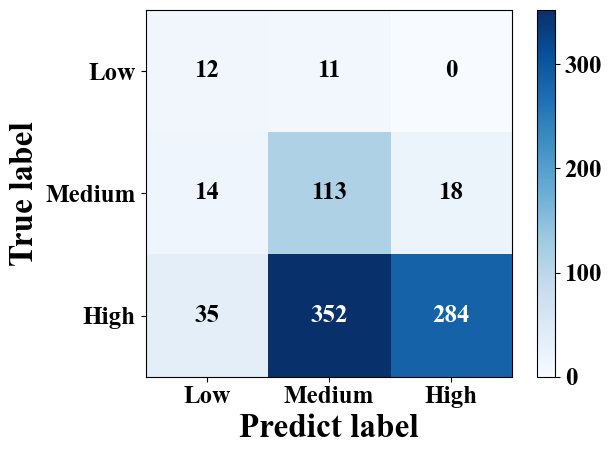

-----------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.8992348565356005
The performance of Algorithm KNN in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm KNN in the test set is as follows: Accuracy: 0.710 macro-Precision: 0.533 macro-Recall: 0.721 macro-F1: 0.573
The accuracy of the model is： 0.7103694874851013
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.28      0.74      0.41        23
           1       0.39      0.72      0.51       145
           2       0.92      0.71      0.80       671

    accuracy                           0.71       839
   macro avg       0.53      0.72      0.57       839
weighted avg       0.81      0.71      0.74       839



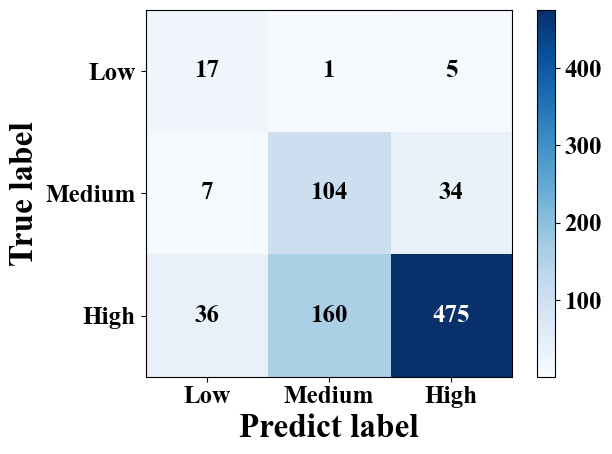

-----------------------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.8873333031858367
The performance of Algorithm SVM in the training set is as follows: Accuracy: 0.923 macro-Precision: 0.927 macro-Recall: 0.923 macro-F1: 0.922
The performance of Algorithm SVM in the test set is as follows: Accuracy: 0.726 macro-Precision: 0.533 macro-Recall: 0.694 macro-F1: 0.572
The accuracy of the model is： 0.7258641239570918
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.29      0.70      0.41        23
           1       0.39      0.64      0.48       145
           2       0.92      0.75      0.82       671

    accuracy                           0.73       839
   macro avg       0.53      0.69      0.57       839
weighted avg       0.81      0.73      0.75       839



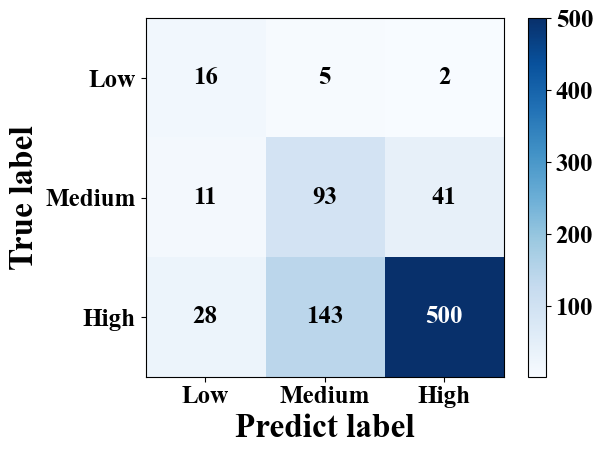

-----------------------------------------------------------------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9547199674407036
The performance of Algorithm RF in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm RF in the test set is as follows: Accuracy: 0.815 macro-Precision: 0.647 macro-Recall: 0.653 macro-F1: 0.648
The accuracy of the model is： 0.8152562574493445
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.54      0.61      0.57        23
           1       0.52      0.45      0.48       145
           2       0.88      0.90      0.89       671

    accuracy                           0.82       839
   macro avg       0.65      0.65      0.65       839
weighted avg       0.8

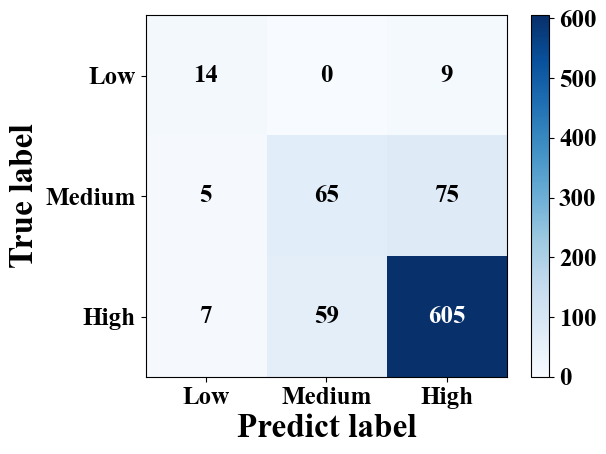

-----------------------------------------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best score: 0.8492787211431929
The performance of Algorithm AdaBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm AdaBoost in the test set is as follows: Accuracy: 0.703 macro-Precision: 0.490 macro-Recall: 0.599 macro-F1: 0.521
The accuracy of the model is： 0.7032181168057211
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.27      0.57      0.36        23
           1       0.33      0.48      0.39       145
           2       0.88      0.76      0.81       671

    accuracy                           0.70       839
   macro avg       0.49      0.60      0.52       839
weighted avg       0.76      0.70      0.73       839



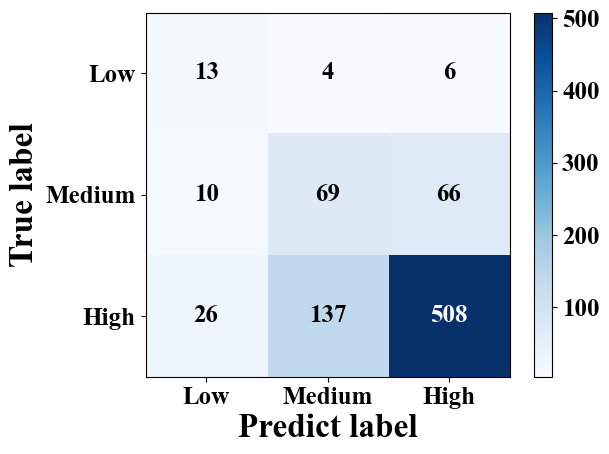

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 200}
Best score: 0.9500461256698397
The performance of Algorithm GBDT in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm GBDT in the test set is as follows: Accuracy: 0.824 macro-Precision: 0.670 macro-Recall: 0.671 macro-F1: 0.670
The accuracy of the model is： 0.8235995232419547
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.58      0.61      0.60        23
           1       0.54      0.50      0.52       145
           2       0.89      0.90      0.89       671

    accuracy                           0.82       839
   macro avg       0.67      0.67      0.67       839
weighted avg       0.82      0.82      0.82     

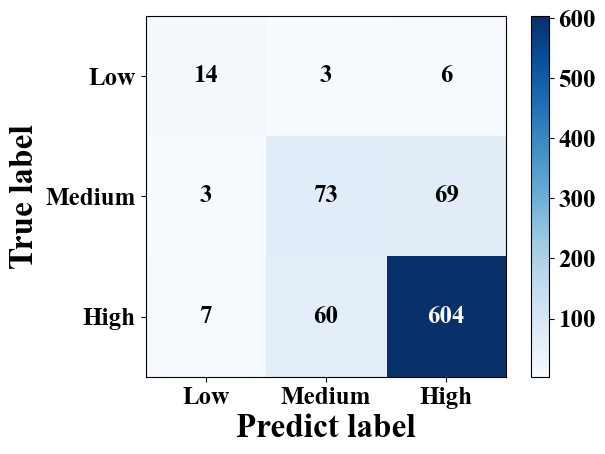

-----------------------------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best score: 0.9515330002034956
The performance of Algorithm XGBoost in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm XGBoost in the test set is as follows: Accuracy: 0.822 macro-Precision: 0.643 macro-Recall: 0.665 macro-F1: 0.652
The accuracy of the model is： 0.8224076281287247
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.50      0.61      0.55        23
           1       0.54      0.48      0.51       145
           2       0.89      0.90      0.90       671

    accuracy                           0.82       839
   macro avg       0.64      0.66      0.65       839
weighted avg       0.82      0.82      0.82       839



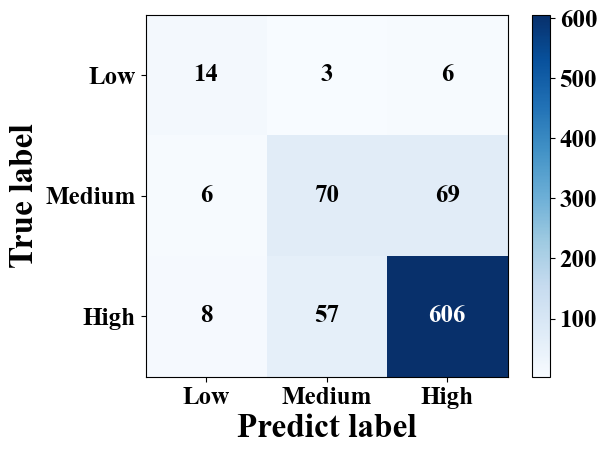

-----------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'boosting_type': 'goss', 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.9610977457209398
The performance of Algorithm LightGBM in the training set is as follows: Accuracy: 1.000 macro-Precision: 1.000 macro-Recall: 1.000 macro-F1: 1.000
The performance of Algorithm LightGBM in the test set is as follows: Accuracy: 0.838 macro-Precision: 0.696 macro-Recall: 0.673 macro-F1: 0.683
The accuracy of the model is： 0.8379022646007152
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.61      0.61      0.61        23
           1       0.59      0.49      0.54       145
           2       0.89      0.92      0.90       671

    accuracy                           0.84       839
   macro avg       0.70      0.67      0.68       839
weighted avg       0.83      0.84   

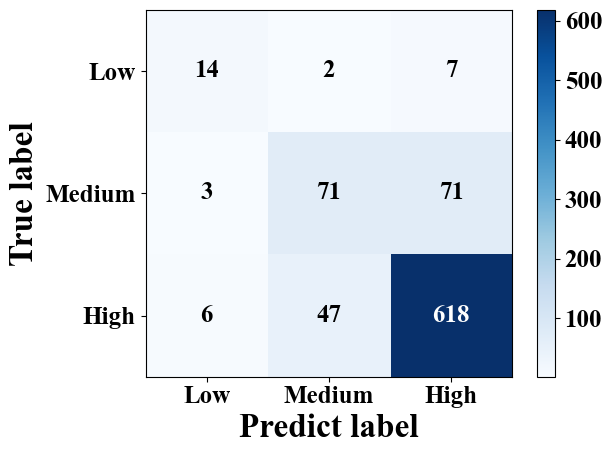

-----------------------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9443046103059217
The performance of Algorithm MLP in the training set is as follows: Accuracy: 0.997 macro-Precision: 0.997 macro-Recall: 0.997 macro-F1: 0.997
The performance of Algorithm MLP in the test set is as follows: Accuracy: 0.806 macro-Precision: 0.612 macro-Recall: 0.704 macro-F1: 0.647
The accuracy of the model is： 0.8057210965435042
Evaluation report of the model：
               precision    recall  f1-score   support

           0       0.43      0.70      0.53        23
           1       0.50      0.55      0.52       145
           2       0.90      0.86      0.88       671

    accuracy                           0.81       839
   macro avg       0.61      0.70      0.65       839
weighted avg       0.82      0.8

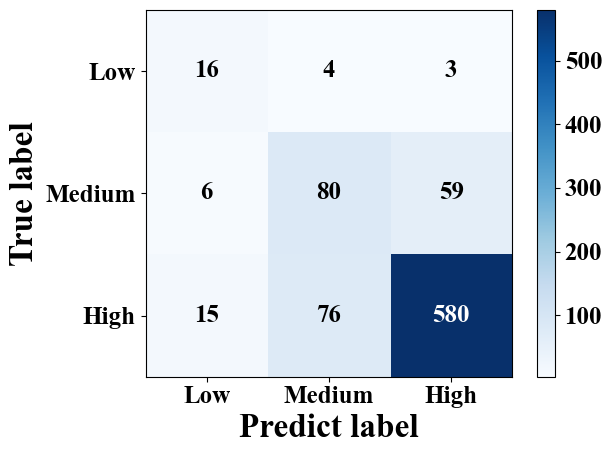

-----------------------------------------------------------------


In [43]:
# Occipital region
EEGZhenQuResultInfo = stepIntegration(EEGZhenQuFeatures, TrustLabel, 'EEG_ZhenQu')

In [44]:
EEGZhenQuResultInfo.to_csv('D:/EEGData/EEG_ZhenQu.csv', index=False, mode='w')

# SHAP drawing

In [45]:
import shap

In [50]:
def datasetSplit(features, label):
    # Call the function to split the dataset into training and testing sets
    xTrain, xTest, yTrain, yTest = dataSplitStandard(features, label, 42)
    
    # Call the feature selection function 
    xTrainRFE, xTestRFE = featureSelect(xTrain, xTest, yTrain, yTest, 420,2, 42, columnNames)
        
    # Call the sample balancing function
    xTrainResample, yTrainResample = resampleFunction(xTrainRFE, yTrain, 42)
    # Print feature information 
    return xTrainResample, yTrainResample, xTestRFE, yTest

In [51]:
import shap

def shapFig(model, features, label, dataType):
    xTrain, yTrain, xTest, yTest = datasetSplit(features, label)

    model.fit(xTrain, yTrain)

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(xTest)

    shap.summary_plot(shap_values, xTest, class_names=['Low','Medium','High'],class_inds=[0,1,2],plot_type="bar",max_display=10,show=False)

    plt.show()

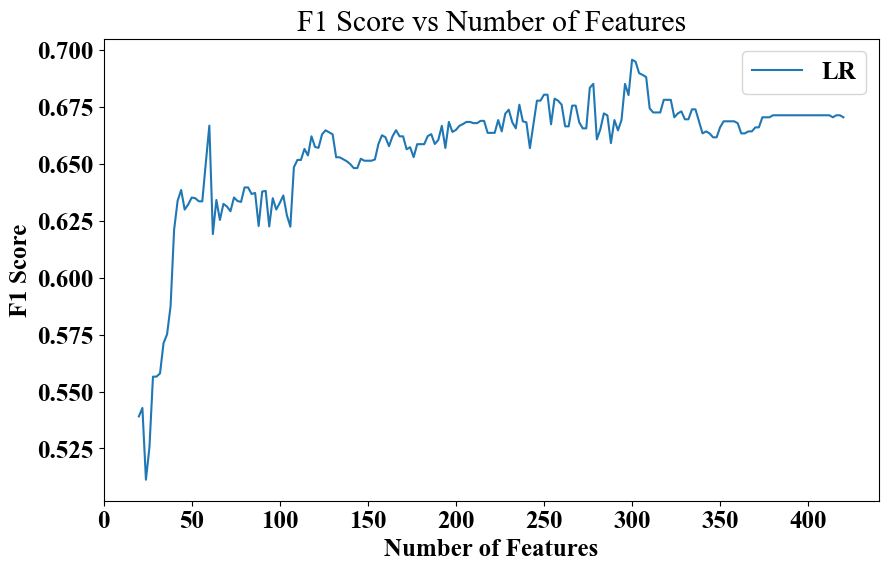

Best Algorithm: LR
Best F1 Score: 0.6956202077234587


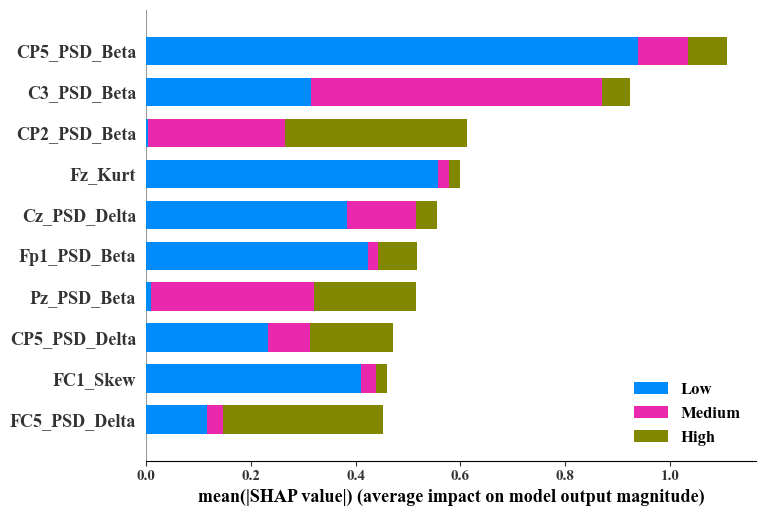

In [52]:
from lightgbm import LGBMClassifier

LGBMModel = LGBMClassifier(n_estimators=200, max_depth=-1, random_state=42)
shapFig(LGBMModel, chEEGFeatures, TrustLabel, 'EEG')

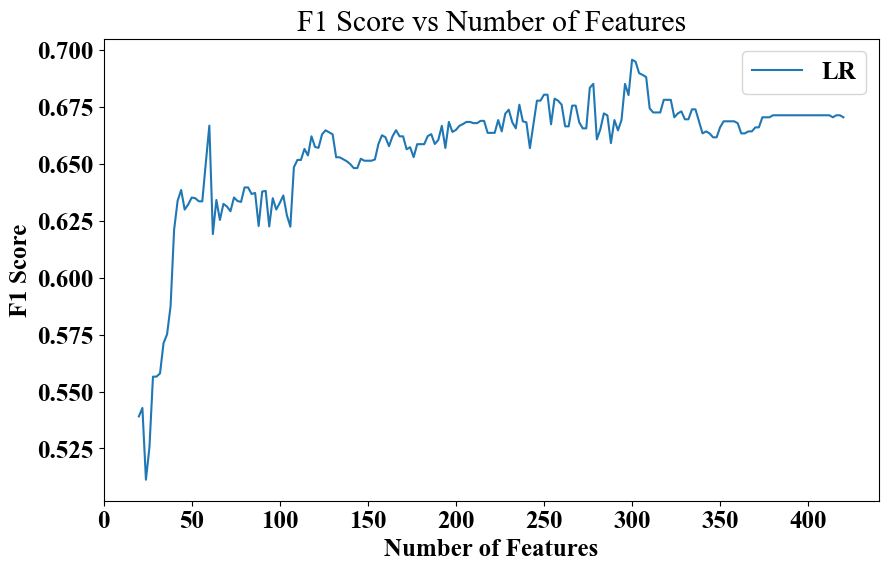

Best Algorithm: LR
Best F1 Score: 0.6956202077234587


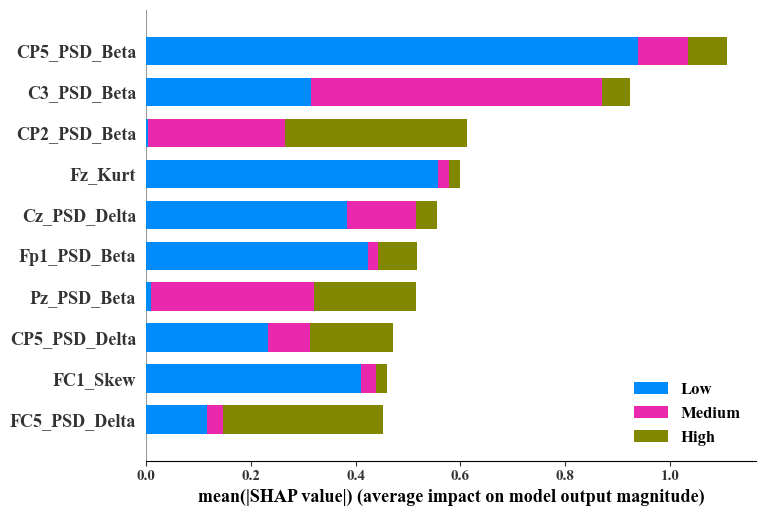

In [53]:
shapFig(LGBMModel, chEEGFeatures, TrustLabel, 'EEG')

In [54]:
def SHAP_summary(model, features, label, dataType):
    xTrain, yTrain, xTest, yTest = datasetSplit(features, label)

    model.fit(xTrain, yTrain)

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(xTest)

    for i in range(3):
        plt.figure(dpi=600)
        plt.xlim(-2.0, 2.0)
        shap.summary_plot(shap_values[i], xTest,max_display=10)
        i+=1
    plt.show()

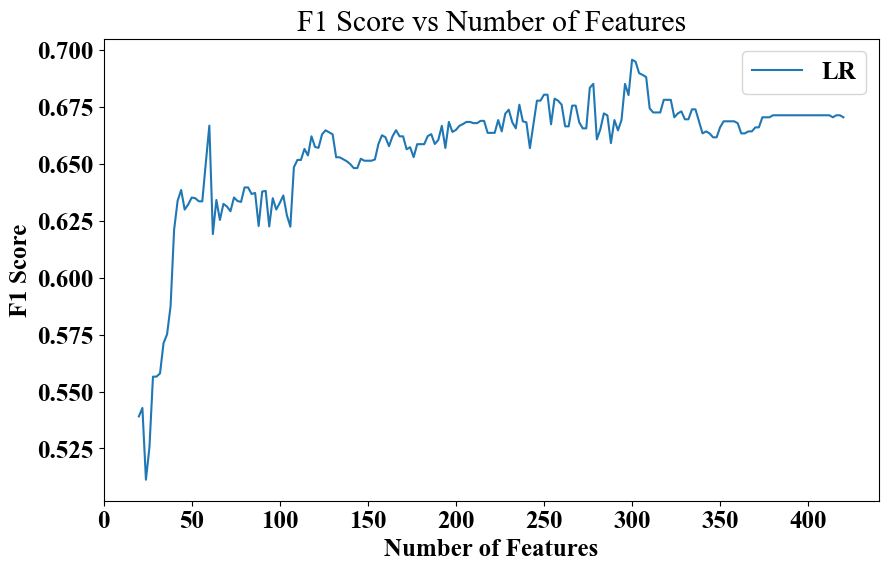

Best Algorithm: LR
Best F1 Score: 0.6956202077234587


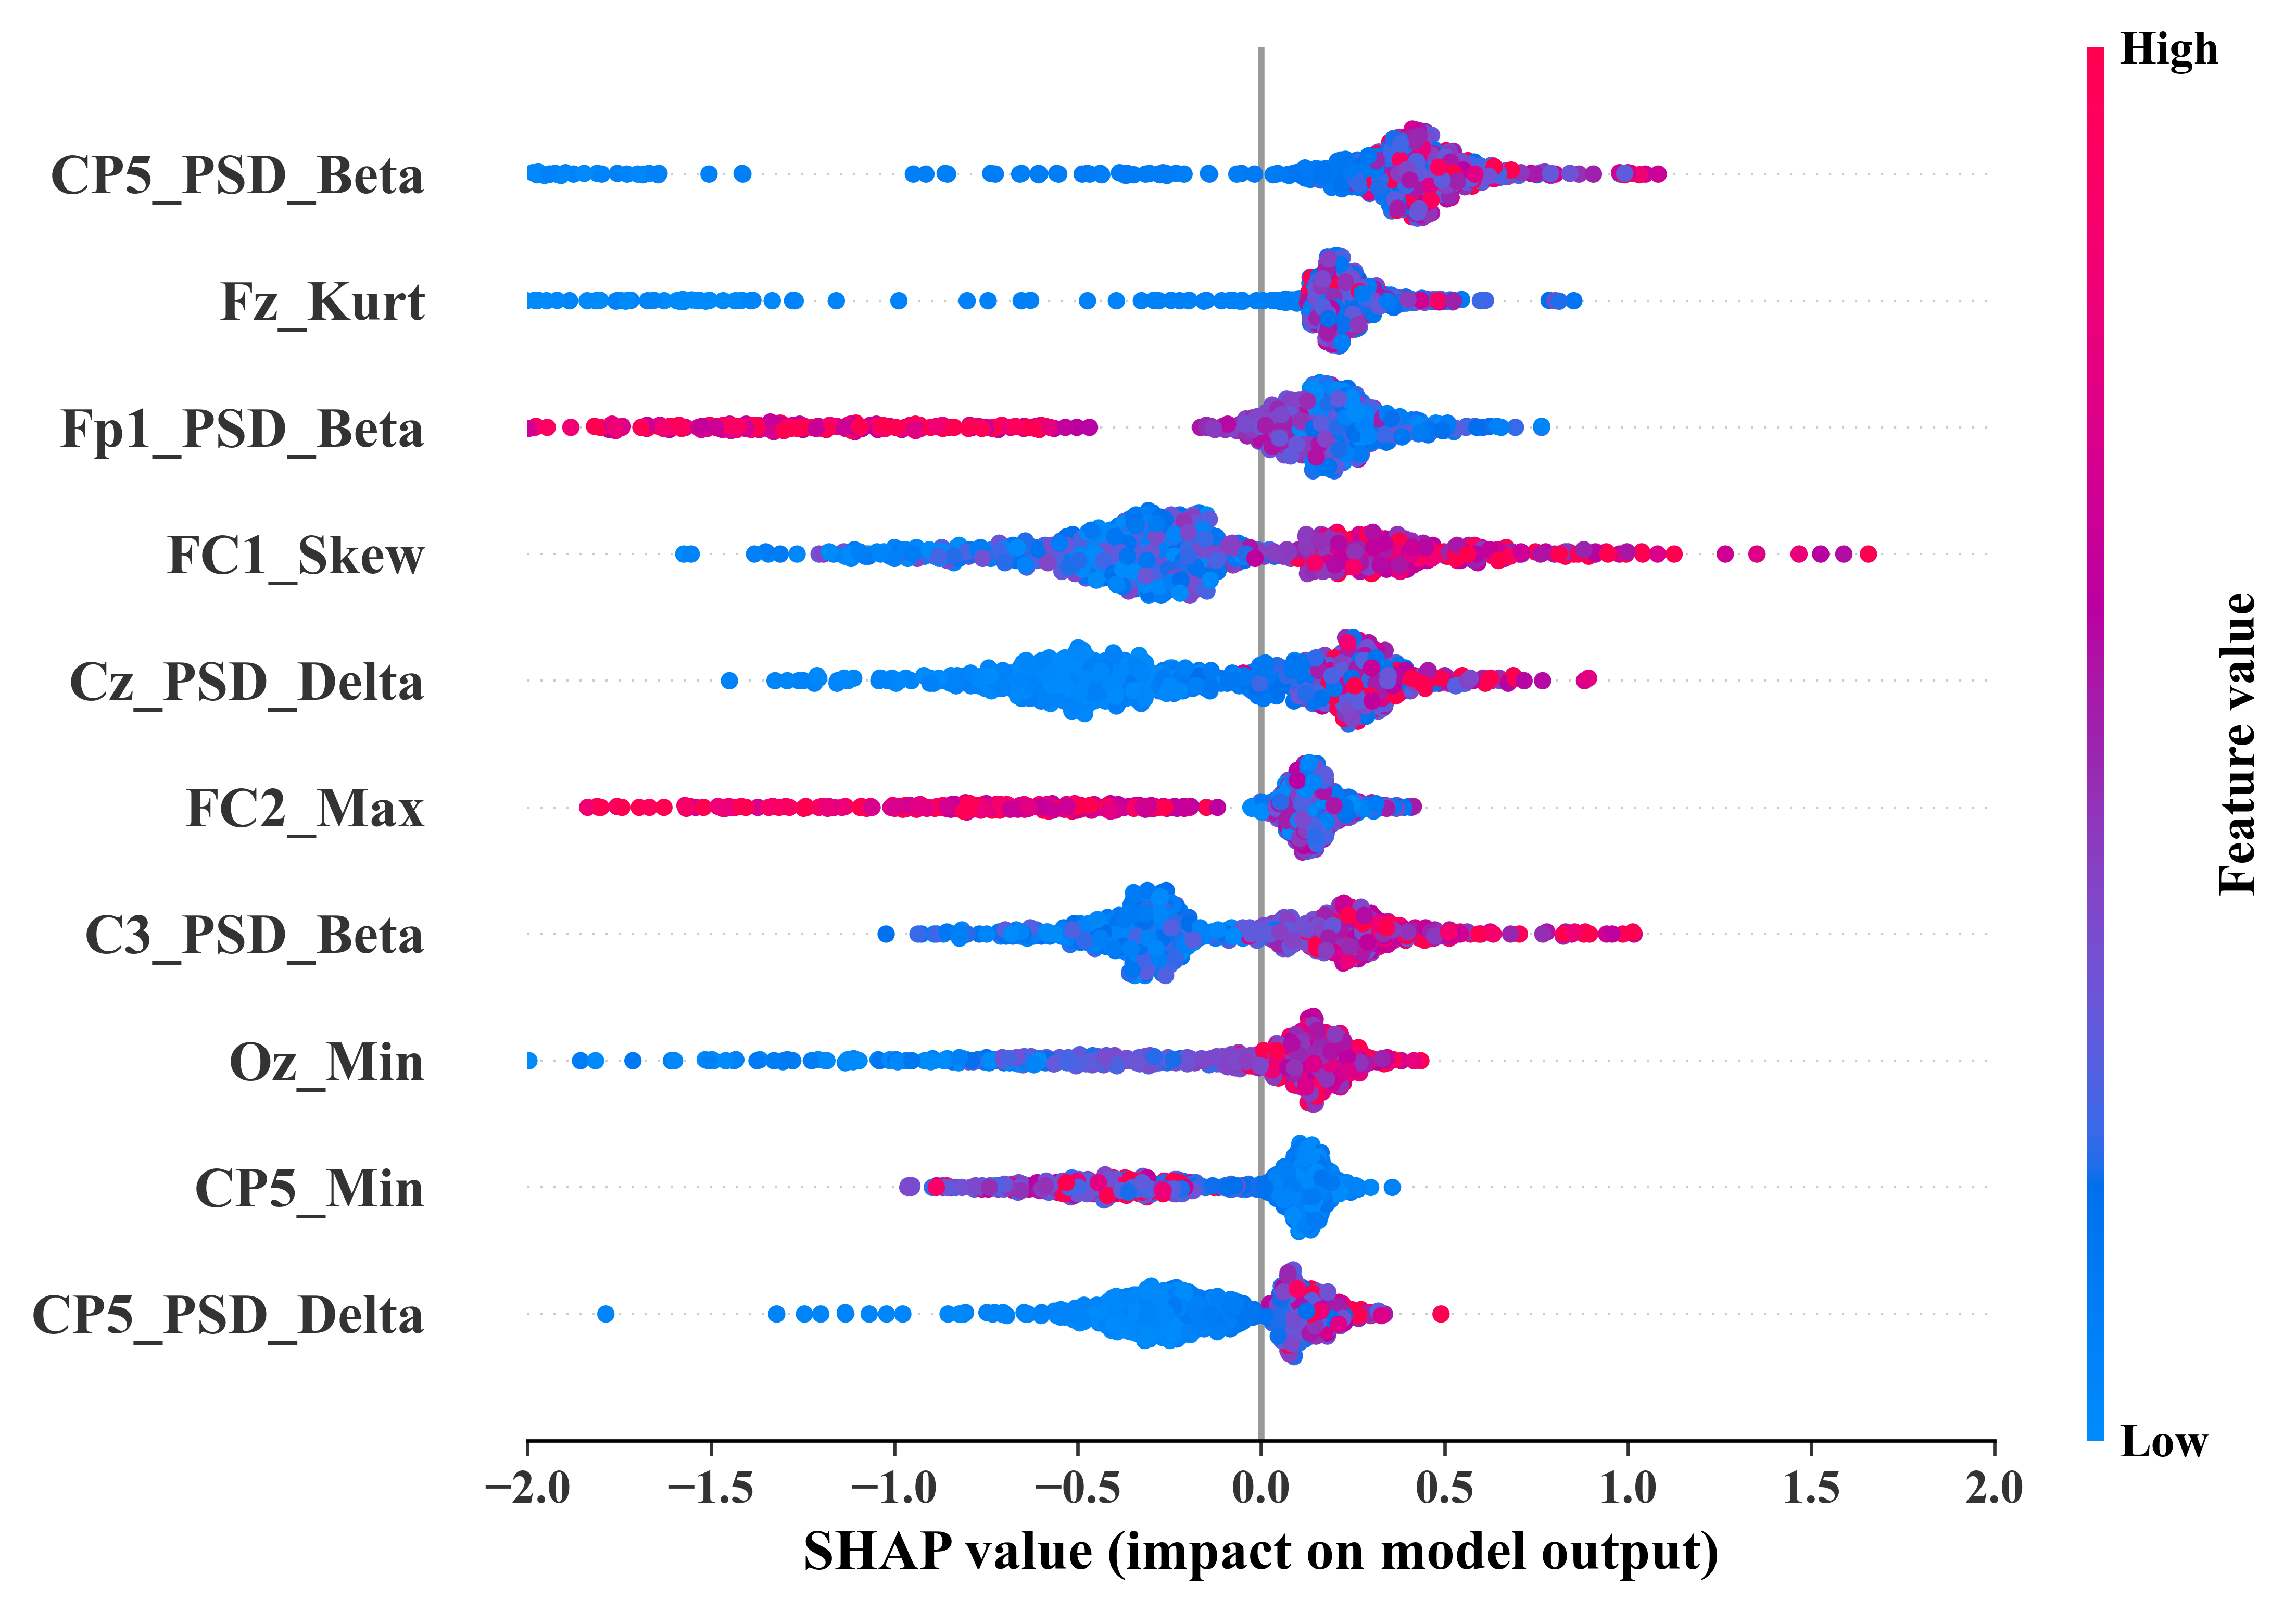

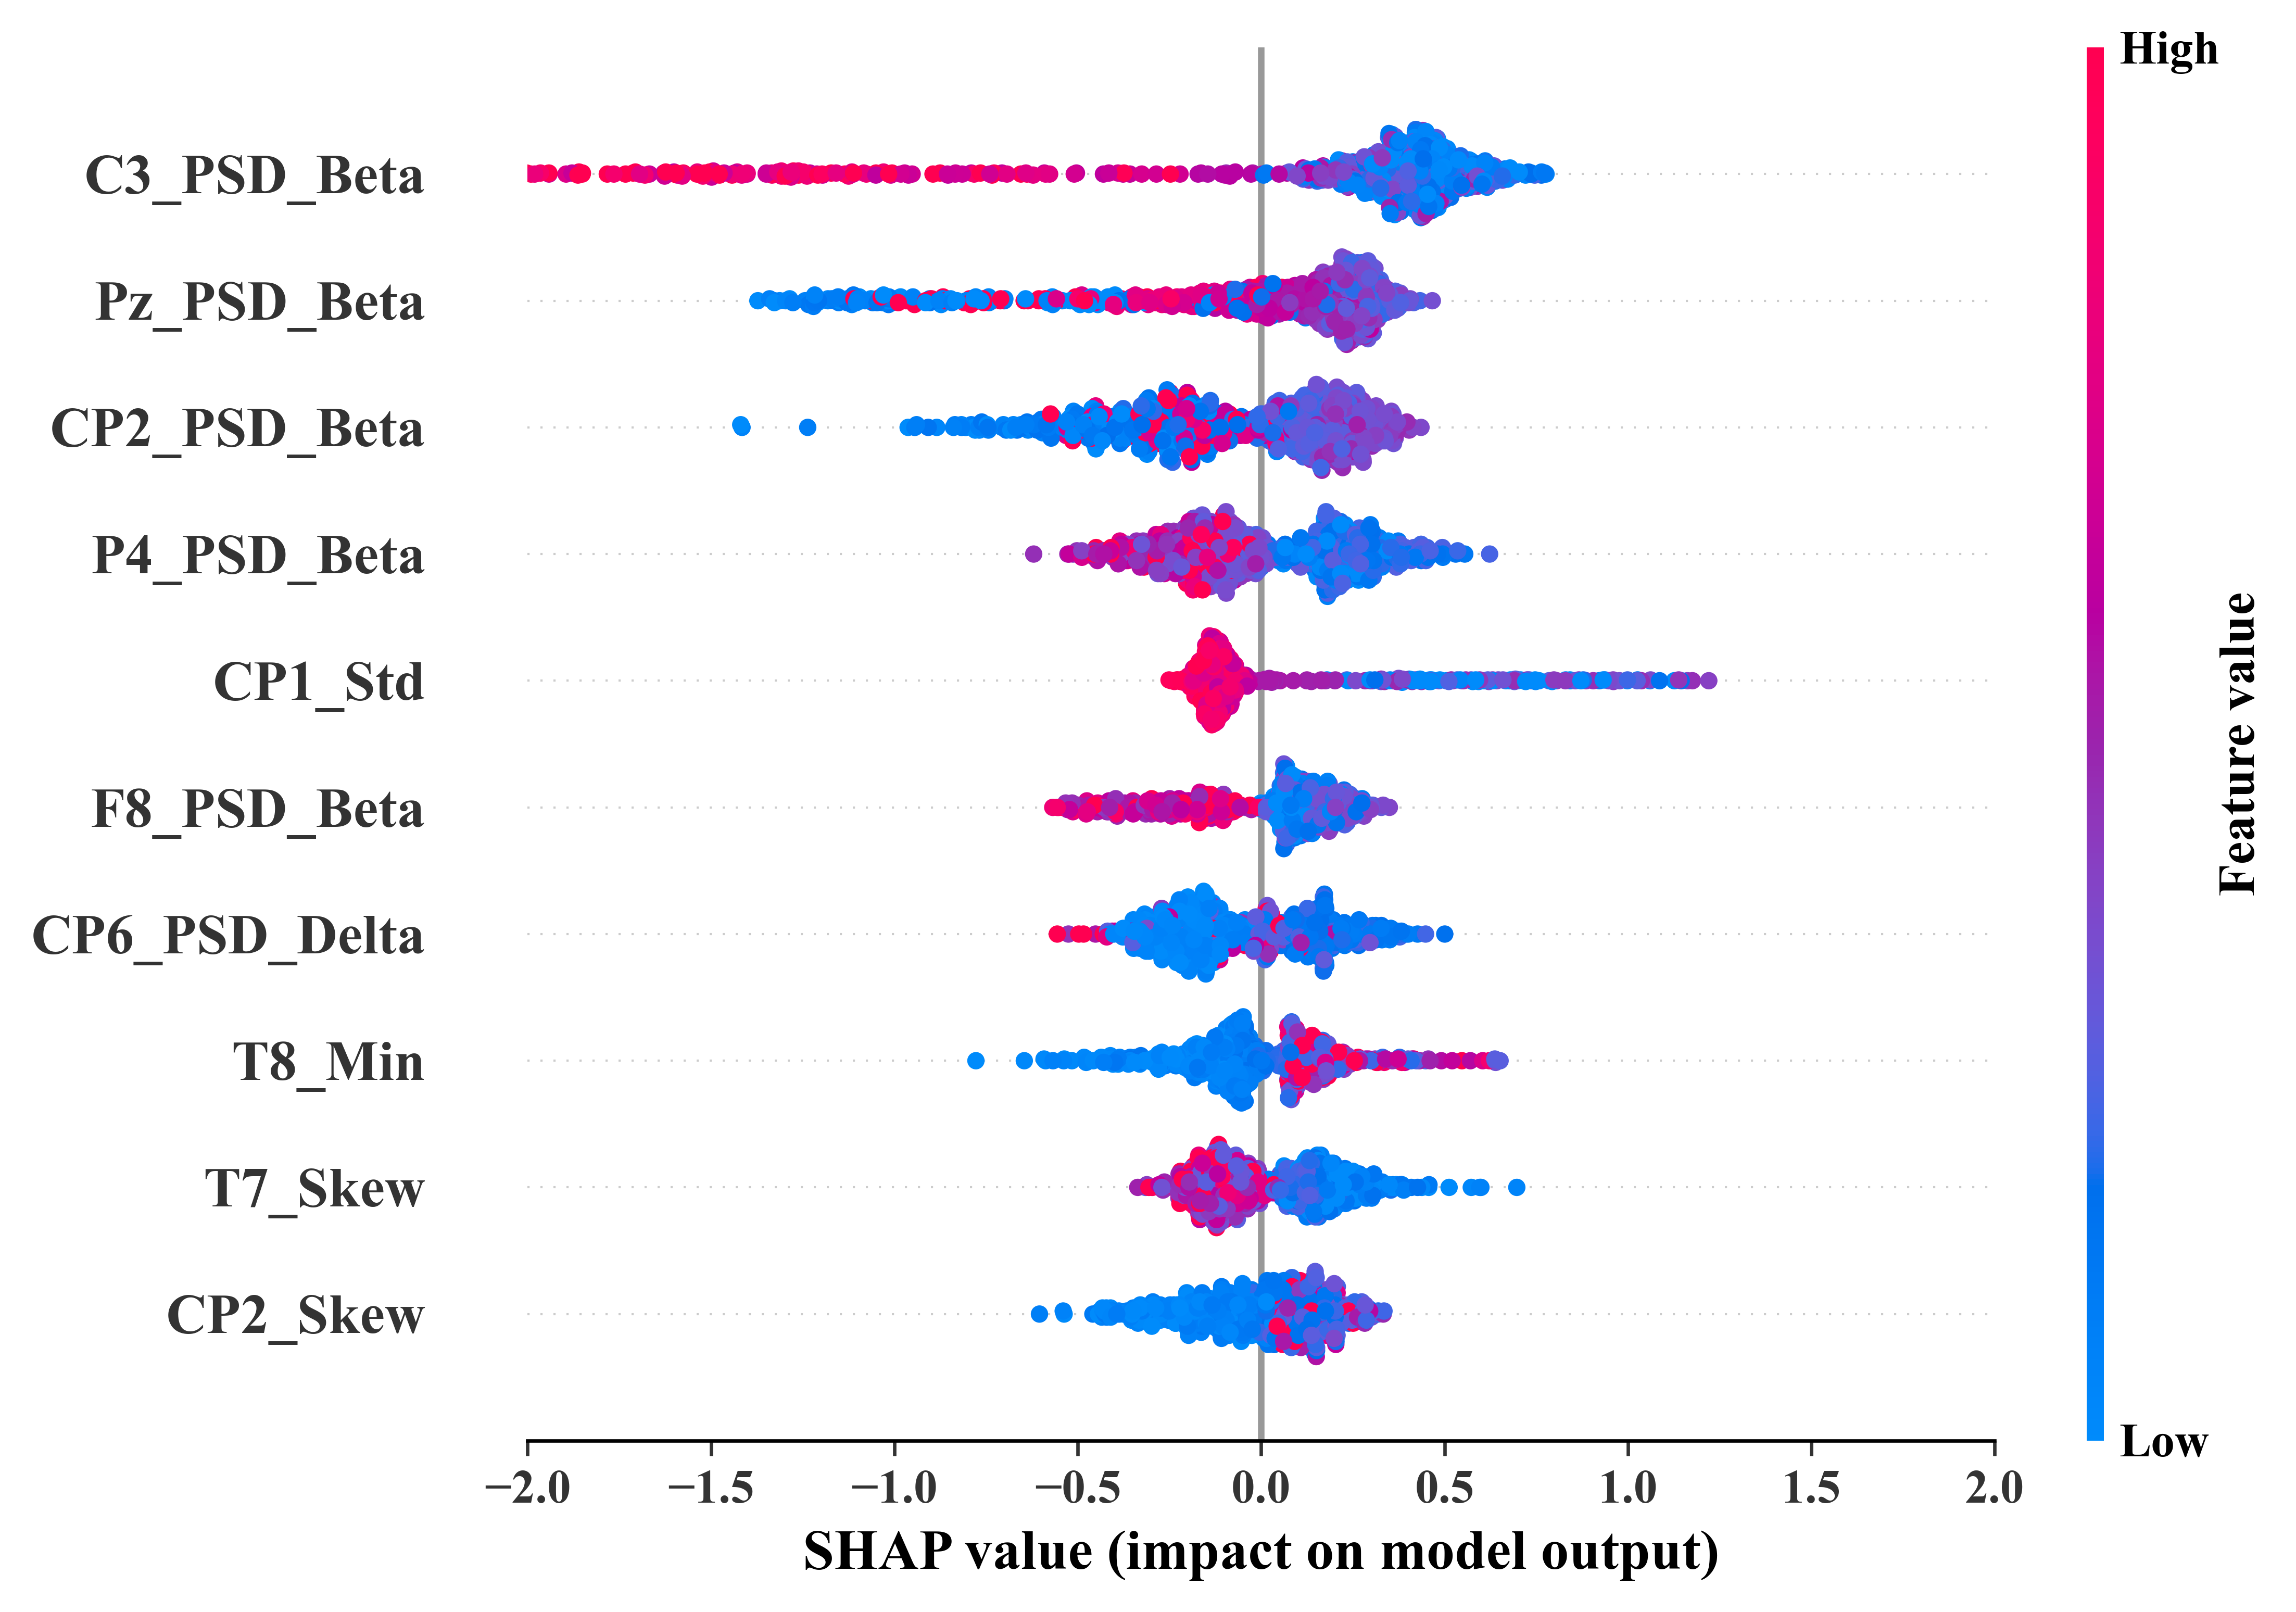

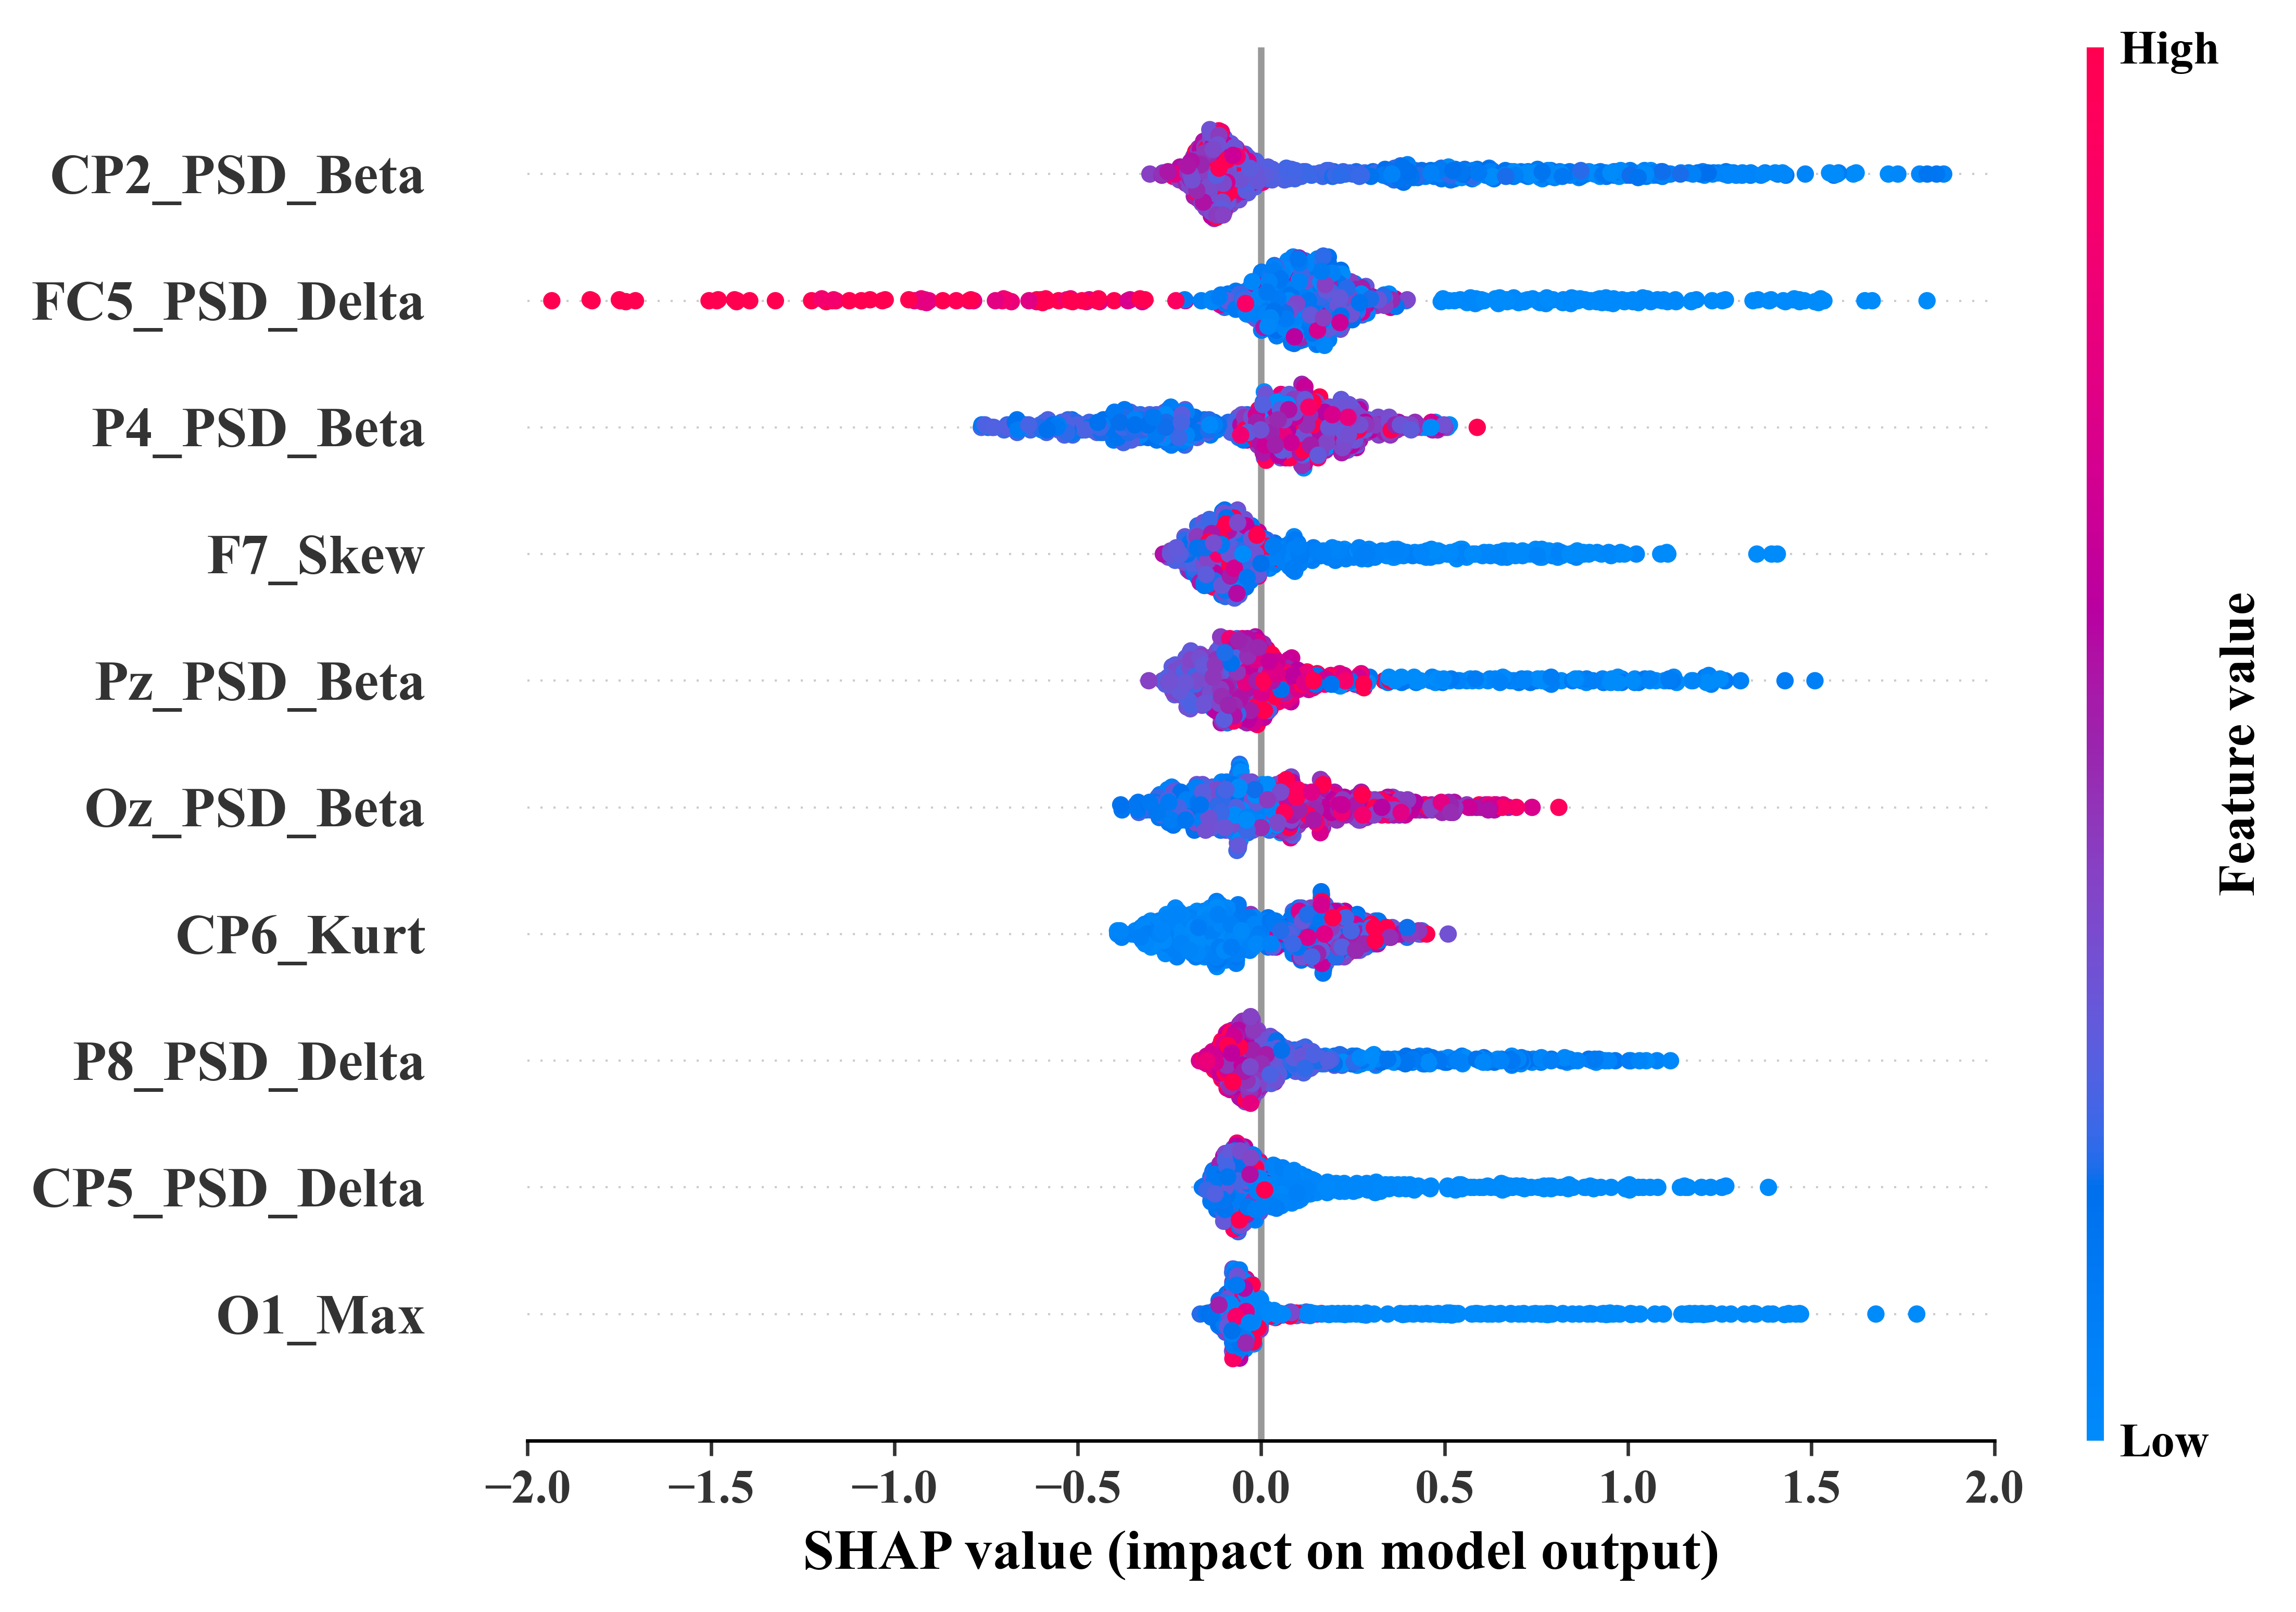

In [55]:
SHAP_summary(LGBMModel, chEEGFeatures, TrustLabel, 'EEG')